In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [18]:
deaths_path = 'time_series_covid19_deaths_US.csv'
deaths_path = covid19.data.download('deaths', repo='usa')
confirmed_path = 'time_series_covid19_deaths_US.csv'
confirmed_path = covid19.data.download('confirmed', repo='usa')
deaths_path, confirmed_path

('time_series_covid19_deaths_US.csv', 'time_series_covid19_confirmed_US.csv')

In [19]:
ds_counties = covid19.data.read_jhu_usa(deaths_path)
ds_counties['confirmed'] = covid19.data.read_jhu_usa(confirmed_path)['confirmed']
ds_counties['mortality'] = ds_counties['deaths'] / ds_counties['population'] * 1_000_000
ds_counties['daily_deaths'] = ds_counties['deaths'].diff('time')
ds_counties['daily_mortality'] = ds_counties['daily_deaths'] / ds_counties['population'] * 1_000_000
ds_counties['daily_mortality7'] = ds_counties['daily_mortality'].rolling({'time': 7}).mean()
ds_counties['daily_confirmed'] = ds_counties['confirmed'].diff('time')
ds_counties['daily_prevalence'] = ds_counties['daily_confirmed'] / ds_counties['population'] * 1_000_000
ds_counties['daily_prevalence7'] = ds_counties['daily_prevalence'].rolling({'time': 7}).mean()

ds_counties = ds_counties.fillna(0)
ds_counties

<xarray.Dataset>
Dimensions:            (location: 3340, time: 202)
Coordinates:
  * time               (time) datetime64[ns] 2020-01-22 ... 2020-08-10
  * location           (location) object 'US / American Samoa / ' ... 'US / Utah / Weber-Morgan'
    state_region       (location) <U29 'US / American Samoa' ... 'US / Utah'
    country            (location) <U2 'US' 'US' 'US' 'US' ... 'US' 'US' 'US'
    lat                (location) float64 -14.27 13.44 15.1 ... 40.12 41.27
    lon                (location) float64 -170.1 144.8 145.7 ... -109.5 -111.9
Data variables:
    population         (location) int64 55641 164229 55144 19483 ... 0 0 0 0
    deaths             (time, location) int64 0 0 0 0 0 0 0 ... 5 7 2 1 26 0 25
    confirmed          (time, location) int64 0 0 0 0 0 ... 113 3223 179 2845
    mortality          (time, location) float64 0.0 0.0 0.0 0.0 ... inf 0.0 inf
    daily_deaths       (time, location) float64 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0
    daily_mortality    (time, location) float64 0.0 0.0 0.0 0.0 ... inf 0.0 0.0
    daily_mortality7   (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    daily_confirmed    (time, location) float64 0.0 0.0 0.0 ... 13.0 0.0 21.0
    daily_prevalence   (time, location) float64 0.0 0.0 0.0 0.0 ... inf 0.0 inf
    daily_prevalence7  (time, location) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [20]:
tmp = ds_counties.sortby(-ds_counties['daily_mortality7'].isel(time=-1)).isel(time=-1)
tmp.sel(location=tmp['population'] > 100_000).to_dataframe().head(20)

population  deaths  confirmed    mortality  \
location                                                                     
US / Texas / Hidalgo                868707     829      20148   954.291838   
US / Florida / Bay                  174705      51       4447   291.920666   
US / Texas / Cameron                423163     430      16590  1016.156895   
US / Texas / Webb                   276652     174       8262   628.949005   
US / Texas / Nueces                 362294     243      15423   670.725985   
US / Florida / St. Lucie            328297     166       5824   505.639710   
US / South Carolina / Florence      138293     116       3480   838.798782   
US / Arizona / Yuma                 213787     289      11609  1351.812786   
US / California / Imperial          181215     244       9693  1346.466904   
US / Mississippi / Madison          106272      68       2443   639.867510   
US / Arizona / Navajo               110924     200       5375  1803.036313   
US / Florida / Martin               161000      94       3838   583.850932   
US / Louisiana / Tangipahoa         134758      77       3498   571.394648   
US / California / Stanislaus        550660     169      10264   306.904442   
US / Georgia / Lowndes              117406      44       3193   374.767899   
US / Florida / Manatee              403253     227       9340   562.922037   
US / Louisiana / Calcasieu          203436     146       6815   717.670422   
US / Georgia / Muscogee             195769      98       4780   500.589981   
US / Texas / Bexar                 2003554     784      42959   391.304652   
US / Florida / Hernando             193920      48       2028   247.524752   

                                daily_deaths  daily_mortality  \
location                                                        
US / Texas / Hidalgo                    22.0        25.324995   
US / Florida / Bay                       0.0         0.000000   
US / Texas / Cameron                     0.0         0.000000   
US / Texas / Webb                        5.0        18.073247   
US / Texas / Nueces                      7.0        19.321325   
US / Florida / St. Lucie                 0.0         0.000000   
US / South Carolina / Florence           1.0         7.231024   
US / Arizona / Yuma                      1.0         4.677553   
US / California / Imperial               0.0         0.000000   
US / Mississippi / Madison               2.0        18.819633   
US / Arizona / Navajo                    0.0         0.000000   
US / Florida / Martin                    0.0         0.000000   
US / Louisiana / Tangipahoa              2.0        14.841419   
US / California / Stanislaus             7.0        12.712018   
US / Georgia / Lowndes                   0.0         0.000000   
US / Florida / Manatee                  35.0        86.794147   
US / Louisiana / Calcasieu               0.0         0.000000   
US / Georgia / Muscogee                  2.0        10.216122   
US / Texas / Bexar                       2.0         0.998226   
US / Florida / Hernando                  1.0         5.156766   

                                daily_mortality7  daily_confirmed  \
location                                                            
US / Texas / Hidalgo                   28.449507            407.0   
US / Florida / Bay                     23.713443              7.0   
US / Texas / Cameron                   20.930806            300.0   
US / Texas / Webb                      19.106004            374.0   
US / Texas / Nueces                    18.927012            179.0   
US / Florida / St. Lucie               17.840988             52.0   
US / South Carolina / Florence         17.561058             44.0   
US / Arizona / Yuma                    17.373768             99.0   
US / California / Imperial             17.343251              0.0   
US / Mississippi / Madison             16.131114             21.0   
US / Arizona / Navajo                  15.454597        

In [21]:
ds_states = ds_counties.groupby('state_region').sum().rename({'state_region': 'location'})
ds_states['mortality'] = ds_states['deaths'] / ds_states['population'] * 1_000_000
ds_states['daily_mortality'] = ds_states['daily_deaths'] / ds_states['population'] * 1_000_000
ds_states['daily_mortality7'] = ds_states['daily_mortality'].rolling({'time': 7}).mean()
ds_states['daily_prevalence'] = ds_states['daily_confirmed'] / ds_states['population'] * 1_000_000
ds_states['daily_prevalence7'] = ds_states['daily_prevalence'].rolling({'time': 7}).mean()
tmp = ds_states.isel(time=-1).copy()
tmp = tmp.sortby(-tmp['daily_mortality7'])
STATES = list(tmp.location.values)
tmp.to_dataframe().head(49)

time  population  deaths  confirmed  \
location                                                              
US / Mississippi          2020-08-10     2976149    1912      67649   
US / Louisiana            2020-08-10     4648794    4287     131961   
US / Florida              2020-08-10    21477737    8277     536961   
US / Texas                2020-08-10    28995881    9230     509581   
US / Arizona              2020-08-10     7278717    4154     187523   
US / South Carolina       2020-08-10     5148714    2048     101159   
US / Nevada               2020-08-10     3080156     963      56972   
US / Georgia              2020-08-10    10617423    4229     219025   
US / Alabama              2020-08-10     4903185    1797     103020   
US / Arkansas             2020-08-10     3017804     555      50028   
US / California           2020-08-10    39512223   10476     574231   
US / Idaho                2020-08-10     1787065     239      25104   
US / Tennessee            2020-08-10     6829174    1233     123914   
US / New Mexico           2020-08-10     2096829     690      22444   
US / Iowa                 2020-08-10     3155070     934      49165   
US / North Carolina       2020-08-10    10488084    2199     137562   
US / Oklahoma             2020-08-10     3956971     605      43963   
US / Massachusetts        2020-08-10     6892503    8741     121315   
US / West Virginia        2020-08-10     1792147     141       7757   
US / Puerto Rico          2020-08-10     3754939     279      22821   
US / Virginia             2020-08-10     8535519    2327     100749   
US / Washington           2020-08-10     7614893    1697      63647   
US / South Dakota         2020-08-10      884659     146       9663   
US / Ohio                 2020-08-10    11689100    3673     101731   
US / Maryland             2020-08-10     6045680    3591      96258   
US / North Dakota         2020-08-10      762062     113       7713   
US / Nebraska             2020-08-10     1934408     348      28696   
US / Montana              2020-08-10     1068778      75       5017   
US / Illinois             2020-08-10    12671821    7846     196699   
US / Utah                 2020-08-10     3205958     345      44390   
US / Indiana              2020-08-10     6732219    3044      74992   
US / Missouri             2020-08-10     6626371    1341      60359   
US / Virgin Islands       2020-08-10      107268       9        547   
US / Wisconsin            2020-08-10     5822434     998      61061   
US / Minnesota            2020-08-10     5639632    1701      61516   
US / District of Columbia 2020-08-10      705749     591      12807   
US / Pennsylvania         2020-08-10    12801989    7314     124221   
US / Kentucky             2020-08-10     4467673     775      35254   
US / Oregon               2020-08-10     4217737     357      21488   
US / Kansas               2020-08-10     2913314     386      31183   
US / Delaware             2020-08-10      973764     591      15634   
US / Michigan             2020-08-10     9986857    6526      97306   
US / Hawaii               2020-08-10     1415872      34       3638   
US / Rhode Island         2020-08-10     1059361    1015      19934   
US / New Jersey           2020-08-10     8882190   15878     185031   
US / Colorado             2020-08-10     5758736    1862      51020   
US / New York             2020-08-10    26161672   32781     421336   
US / Connecticut          2020-08-10     3565287    4444      50567   
US / Wyoming              2020-08-10      578759      28       3042   

                             mortality  daily_deaths  daily_mortality  \
location                                                                
US / Mississippi            642.440953          16.0         5.376075   
US / Louisiana              922.174654          24.0         5.162629   
US / Florida                385.375796          91.0         4.236945   
US / Texas                  318.321075       

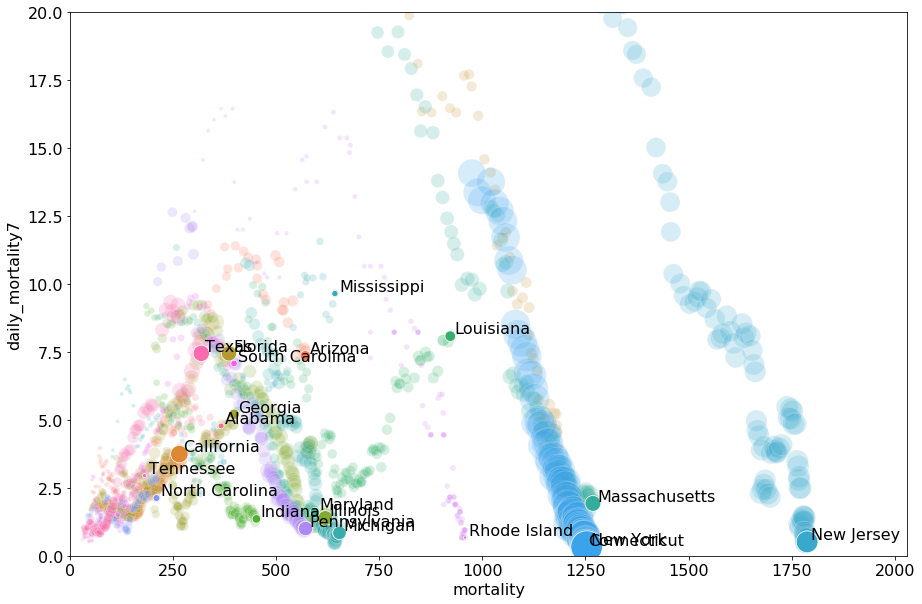

In [22]:
# sns.set()

world_hit = ds_states.sel(location=(((ds_states['daily_mortality7'].isel(time=-1) > 2.) | (ds_states['mortality'] > 400).any('time')) & (ds_states['deaths'] > 1_000)).any('time')).isel(time=slice(-100, None)).to_dataframe().reset_index()
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 20), xlim=(0, 2030))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    ax.annotate(record['location'].partition('US / ')[2], (record['mortality'] + 10, record['daily_mortality7'] + .1))

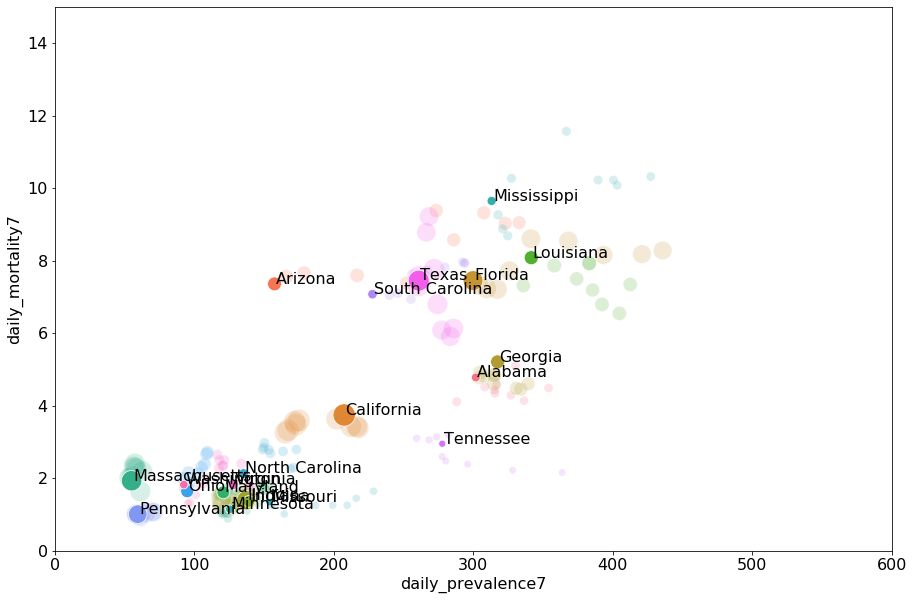

In [23]:
world_hit = ds_states.sel(location=(((ds_states['daily_mortality7'].isel(time=-1) > 1.) & (ds_states['mortality'] > 0).any('time')) & (ds_states['deaths'] > 1_000)).any('time')).isel(time=slice(-10, None)).to_dataframe().reset_index()
ax = sns.scatterplot(x="daily_prevalence7", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(50, 500), legend=False)
ax = sns.scatterplot(x="daily_prevalence7", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(50, 500), legend=False)
_ = ax.set(ylim=(0, 15), xlim=(0, 600))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    if record['daily_mortality7'] > 15:
        continue
    ax.annotate(record['location'].partition('US / ')[2], (record['daily_prevalence7'] + 1, record['daily_mortality7'] + .01))

In [24]:
#### DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())


EXTENT = ('2020-03-15', '2020-08-15')
XLIM = tuple(map(np.datetime64, EXTENT))

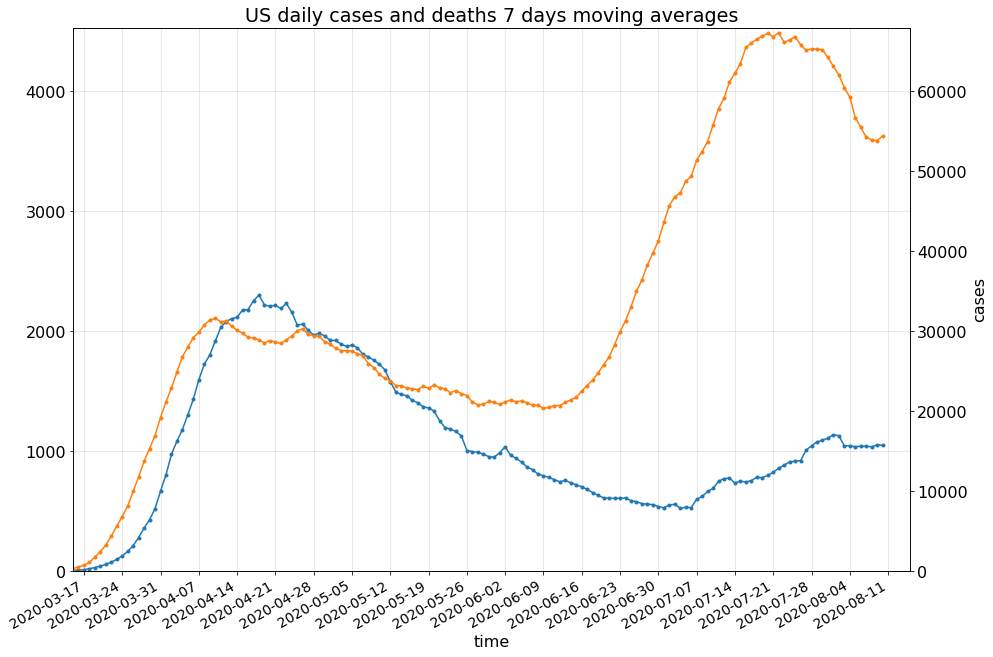

In [25]:
_, ax1 = covid19.plot.subplots(subplot_kw={'xlim': XLIM})
ax1.set(title=f'COVID-19 USA - Linear scale')
ax2 = ax1.twinx()

usa = ds_states.sum('location')

covid19.plot.plot_data(ax1, usa['daily_deaths'].rolling({'time': 7}).mean())
covid19.plot.plot_data(ax2, usa['daily_confirmed'].rolling({'time': 7}).mean())

ax1.set(ylim=(0, usa['population'] / 15 / 5_000), title='US daily cases and deaths 7 days moving averages') 
_ = ax2.set(ylim=(0, usa['population'] / 5_000), ylabel='cases') 


pippo
time              
2020-01-22     NaN
2020-01-23     NaN
2020-01-24     NaN
2020-01-25     NaN
2020-01-26     NaN
...            ...
2020-08-06  7302.0
2020-08-07  7299.0
2020-08-08  7264.0
2020-08-09  7373.0
2020-08-10  7359.0

[202 rows x 1 columns]

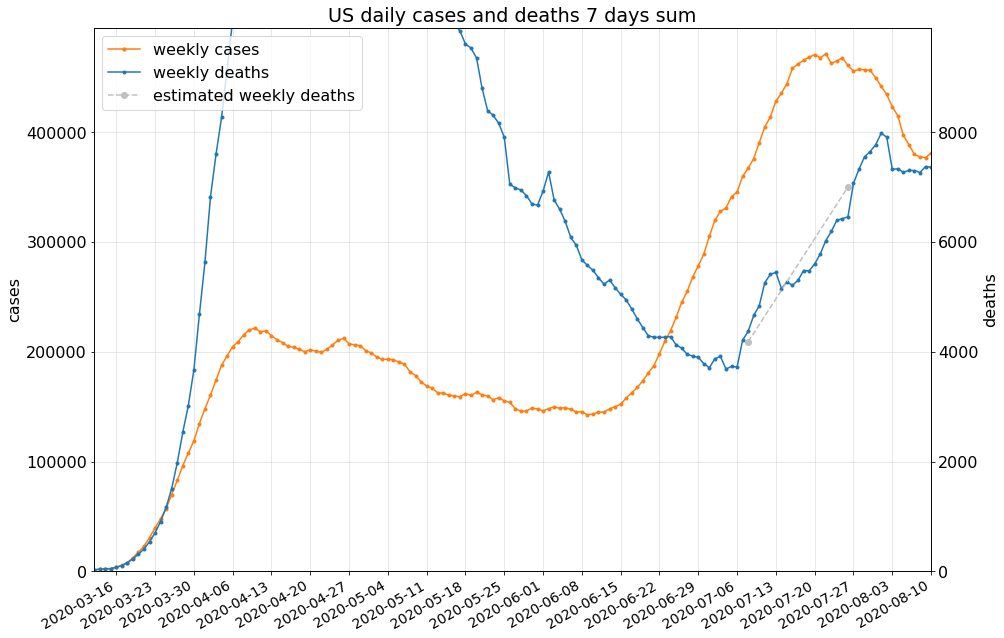

In [26]:
fig, ax1 = covid19.plot.subplots(subplot_kw={'xlim': tuple(map(np.datetime64, ('2020-03-12', '2020-08-10')))})
ax2 = ax1.twinx()

usa = ds_states.sum('location')

ax2.plot([0], [0], 'o-', color='tab:orange', label='weekly cases', markersize=3.25)
covid19.plot.plot_data(ax2, usa['daily_deaths'].rolling({'time': 7}).sum(), color='tab:blue', label='weekly deaths')
covid19.plot.plot_data(ax1, usa['daily_confirmed'].rolling({'time': 7}).sum(), color='tab:orange')
ax2.plot(tuple(map(np.datetime64, ['2020-07-08', '2020-07-26'])), [4180, 7000], 'o--', color='silver', label='estimated weekly deaths')


ax2.set(ylim=(0, 9900), title='US daily cases and deaths 7 days sum', ylabel='deaths') 
ax1.yaxis.set_label_position("left")
ax2.legend(loc='upper left')
_ = ax1.set(ylim=(0, 9900 * 50), ylabel='cases', xlabel='') 
usa['daily_deaths'].rolling({'time': 7}).sum().rename('pippo').to_dataframe()

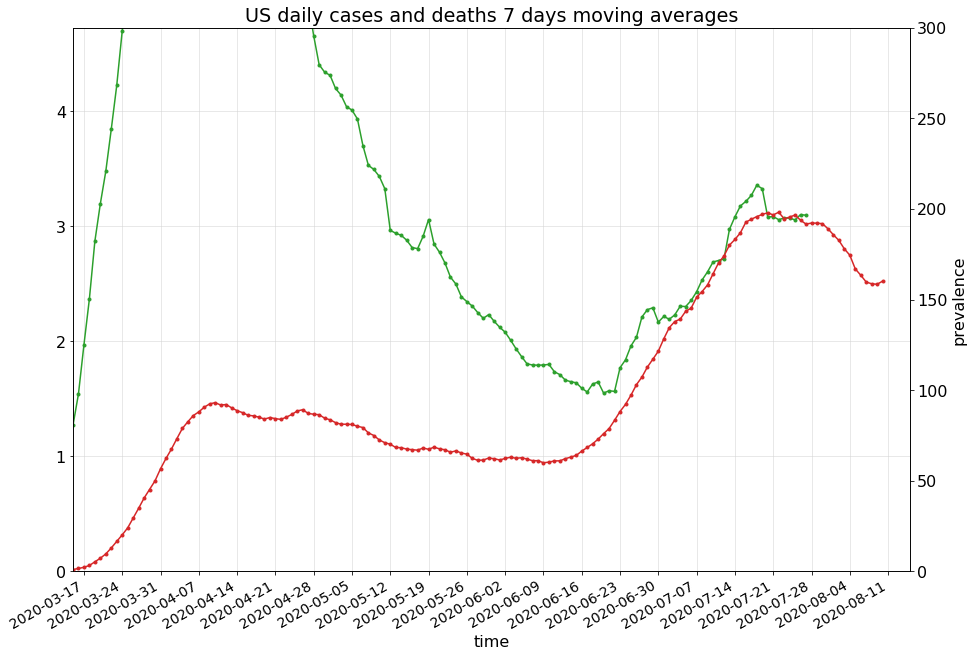

In [27]:
_, ax1 = covid19.plot.subplots(subplot_kw={'xlim': XLIM})
ax1.set(title=f'COVID-19 USA - Linear scale')
ax2 = ax1.twinx()

usa = ds_states.sum('location')
usa['mortality'] = usa['deaths'] / usa['population'] * 1_000_000
usa['daily_mortality'] = usa['daily_deaths'] / usa['population'] * 1_000_000
usa['daily_mortality7'] = usa['daily_mortality'].rolling({'time': 7}).mean()
usa['daily_prevalence'] = usa['daily_confirmed'] / usa['population'] * 1_000_000
usa['daily_prevalence7'] = usa['daily_prevalence'].rolling({'time': 7}).mean()


covid19.plot.plot_data(ax1, usa['daily_mortality7'], delay=-14)
# covid19.plot.plot_data(ax2, usa['daily_prevalence7'])
covid19.plot.plot_data(ax2, usa['daily_prevalence7'])
ax1.set(ylim=(0, 300. * 0.01575), title='US daily cases and deaths 7 days moving averages', ylabel='') 
_ = ax2.set(ylim=(0, 300.), ylabel='prevalence') 


In [28]:
usa.to_dataframe().tail(20)

population  deaths  confirmed   mortality  daily_deaths  \
time                                                                  
2020-07-22   339573798  144035    3970121  424.164058        1211.0   
2020-07-23   339573798  145156    4038816  427.465255        1121.0   
2020-07-24   339573798  146279    4112531  430.772341        1123.0   
2020-07-25   339573798  147180    4178970  433.425667         901.0   
2020-07-26   339573798  147657    4233923  434.830369         477.0   
2020-07-27   339573798  148782    4290337  438.143346        1125.0   
2020-07-28   339573798  150150    4356206  442.171925        1368.0   
2020-07-29   339573798  151586    4426982  446.400756        1436.0   
2020-07-30   339573798  152802    4495015  449.981715        1216.0   
2020-07-31   339573798  154048    4562107  453.651021        1246.0   
2020-08-01   339573798  155159    4620592  456.922769        1111.0   
2020-08-02   339573798  155565    4668172  458.118385         406.0   
2020-08-03   339573798  156104    4713540  459.705669         539.0   
2020-08-04   339573798  157482    4771080  463.763697        1378.0   
2020-08-05   339573798  158854    4823890  467.804056        1372.0   
2020-08-06   339573798  160104    4883582  471.485141        1250.0   
2020-08-07   339573798  161347    4941755  475.145612        1243.0   
2020-08-08   339573798  162423    4997929  478.314290        1076.0   
2020-08-09   339573798  162938    5044864  479.830897         515.0   
2020-08-10   339573798  163463    5094400  481.376952         525.0   

            daily_mortality  daily_mortality7  daily_confirmed  \
time                                                             
2020-07-22         3.566235          2.533428          70910.0   
2020-07-23         3.301197          2.604105          68695.0   
2020-07-24         3.307087          2.689506          73715.0   
2020-07-25         2.653326          2.702547          66439.0   
2020-07-26         1.404702          2.716010          54953.0   
2020-07-27         3.312976          2.973055          56414.0   
2020-07-28         4.028579          3.082015          65869.0   
2020-07-29         4.228830          3.176671          70776.0   
2020-07-30         3.580959          3.216637          68033.0   
2020-07-31         3.669305          3.268383          67092.0   
2020-08-01         3.271748          3.356729          58485.0   
2020-08-02         1.195616          3.326859          47580.0   
2020-08-03         1.587284          3.080332          45368.0   
2020-08-04         4.058028          3.084539          57540.0   
2020-08-05         4.040359          3.057614          52810.0   
2020-08-06         3.681085          3.071918          59692.0   
2020-08-07         3.660471          3.070656          58173.0   
2020-08-08         3.168678          3.055932          56174.0   
2020-08-09         1.516607          3.101787          46935.0   
2020-08-10         1.546056          3.095898          49536.0   

            daily_prevalence  daily_prevalence7  
time                                             
2020-07-22        208.820588         198.239677  
2020-07-23        202.297705         194.638524  
2020-07-24        217.080942         195.545964  
2020-07-25        195.654083         196.699090  
2020-07-26        161.829329         193.798816  
2020-07-27        166.131781         191.694077  
2020-07-28        193.975508         192.255705  
2020-07-29        208.425975         192.199332  
2020-07-30        200.348202         191.920832  
2020-07-31        197.577082         189.134566  
2020-08-01        172.230603         185.788354  
2020-08-02        140.116818         182.686567  
2020-08-03        133.602770         178.039565  
2020-08-04        169.447703         174.535593  
2020-08-05        155.518477         166.977379  
2020-08-06        175.785059         163.468359  
2020-08-07        171.311804         159.716176  
2020-08-08        165.425013         158.74394

In [29]:
STATES_FIT_PARAMS = {
    'US / New York': {
        'deaths': ['2020-03-22', '2020-04-04'],
    },
    'US / New Jersey': {
        'deaths': [None, '2020-04-05', '2020-04-05'],
    },
    'US / Connecticut': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Massachusetts': {
        'deaths': [None, '2020-04-07'],
    },
    'US / Louisiana': {
        'deaths': [None, '2020-04-01'],
    },
    'US / District of Columbia': {
        'deaths': [None, '2020-04-01'],
    },
    'US / Michigan': {
        'deaths': ['2020-03-25', '2020-04-02', None],
    },
    'US / Rhode Island': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Pennsylvania': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Maryland': {
        'deaths': [None, None],
    },
    'US / Illinois': {
        'deaths': [None, '2020-04-10'],
    },
    'US / Indiana': {
        'deaths': [None, '2020-04-08'],
    },
    'US / Colorado': {
        'deaths': [None, None],
    },
    'US / Washington': {
        'deaths': [None, '2020-03-26', '2020-04-10'],
    },
    'US / Georgia': {
        'deaths': [None, '2020-04-10'],
    },
    'US / California': {
        'deaths': [None, '2020-03-26', None],
    },
    'US / Florida': {
        'deaths': [None, None],
    },
    'US / Delaware': {
        'deaths': [None, None],
    },
    'US / Nebraska': {
        'deaths': [None, None],
    },
}

In [30]:
region_fits = {}
for region, params in list(STATES_FIT_PARAMS.items()):
    region_fits[region] = {}
    for kind, breaks in params.items():
        ds = ds_states.sel(location=region)
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)
        if 'daily_' + kind in ds:
            kinf = 'daily_' + kind 
            region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds[kind], breaks)


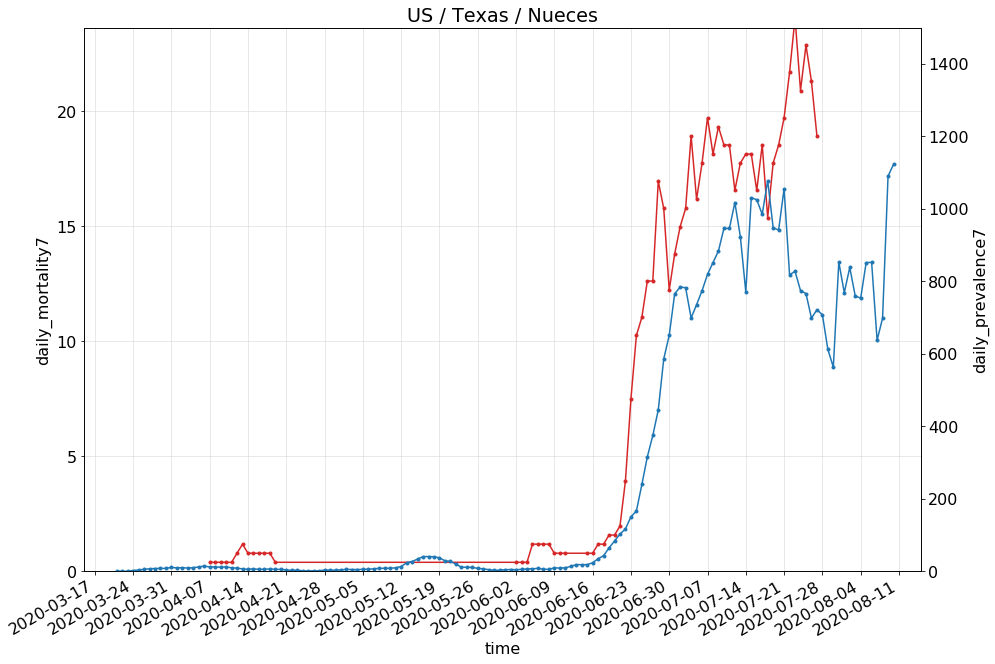

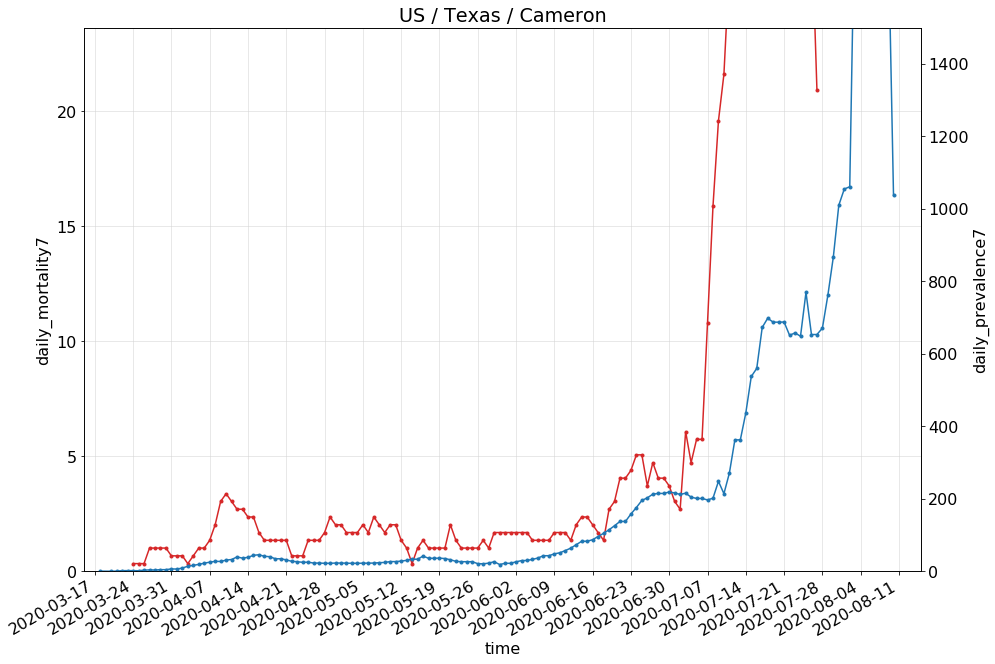

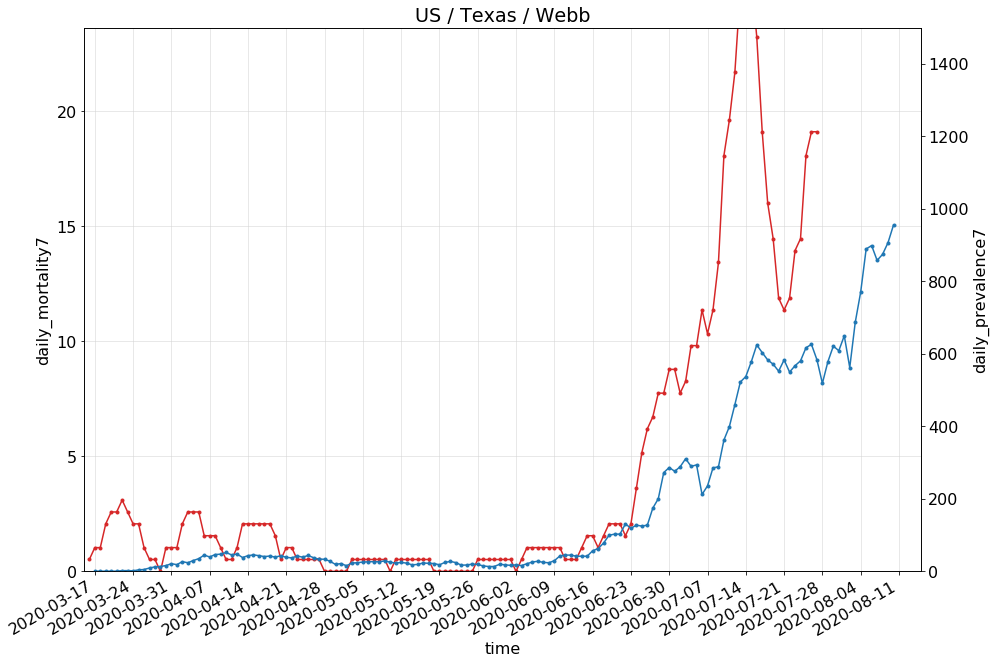

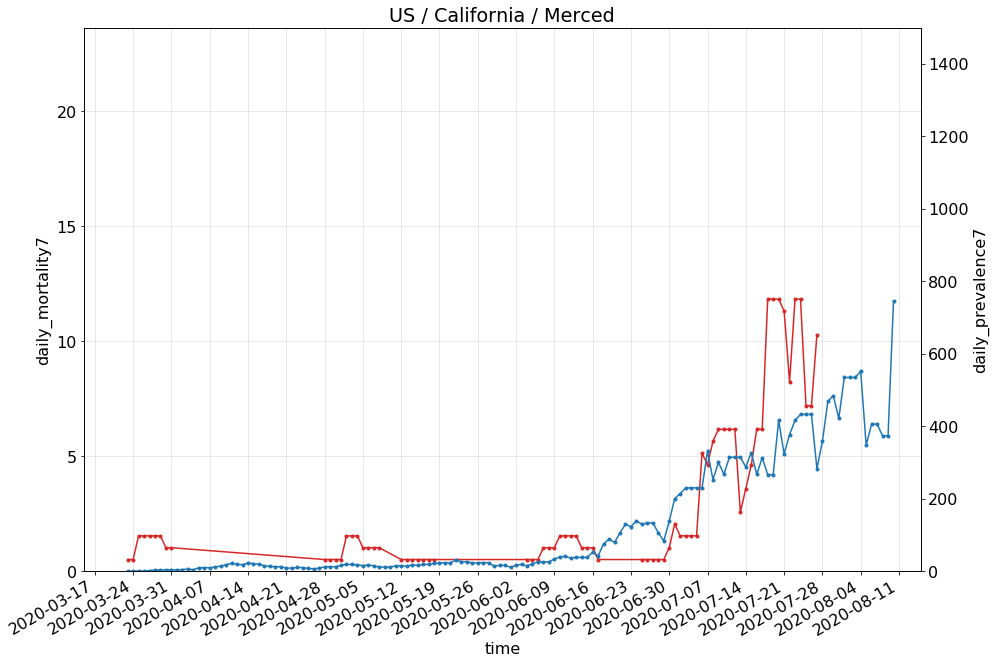

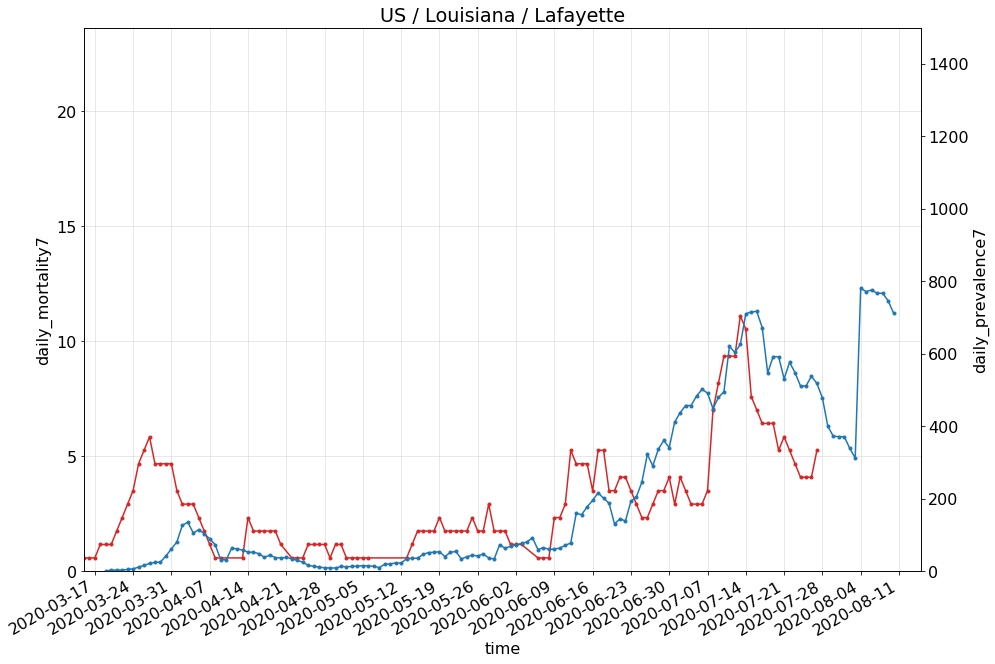

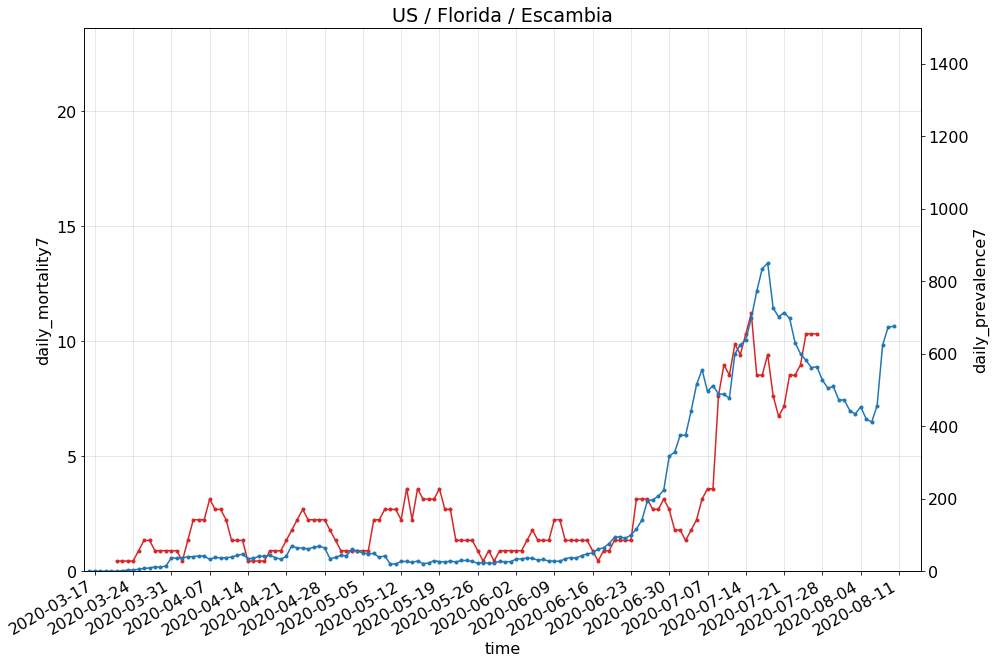

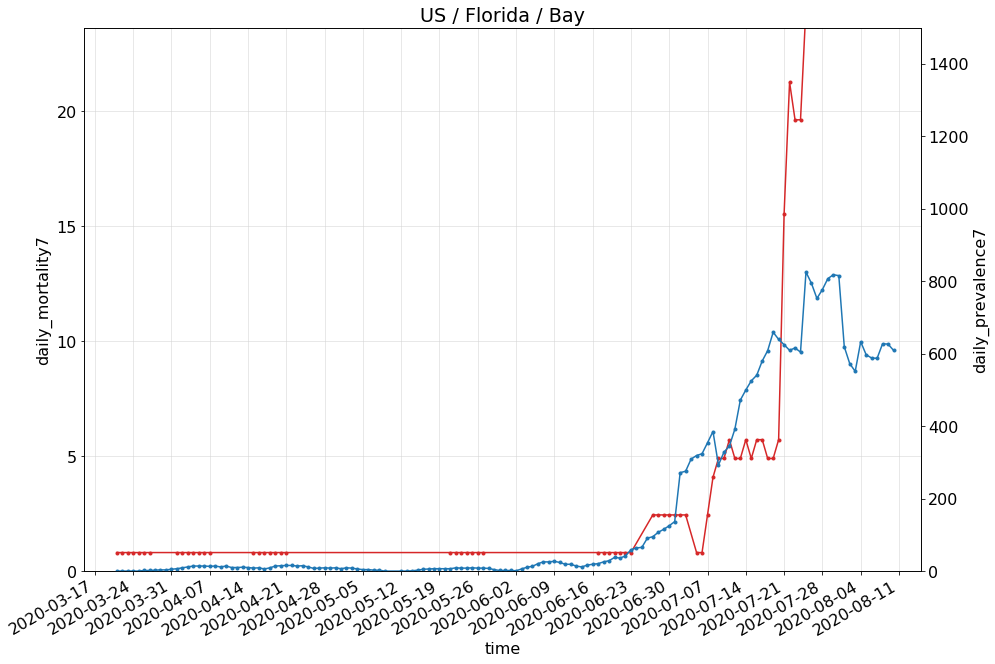

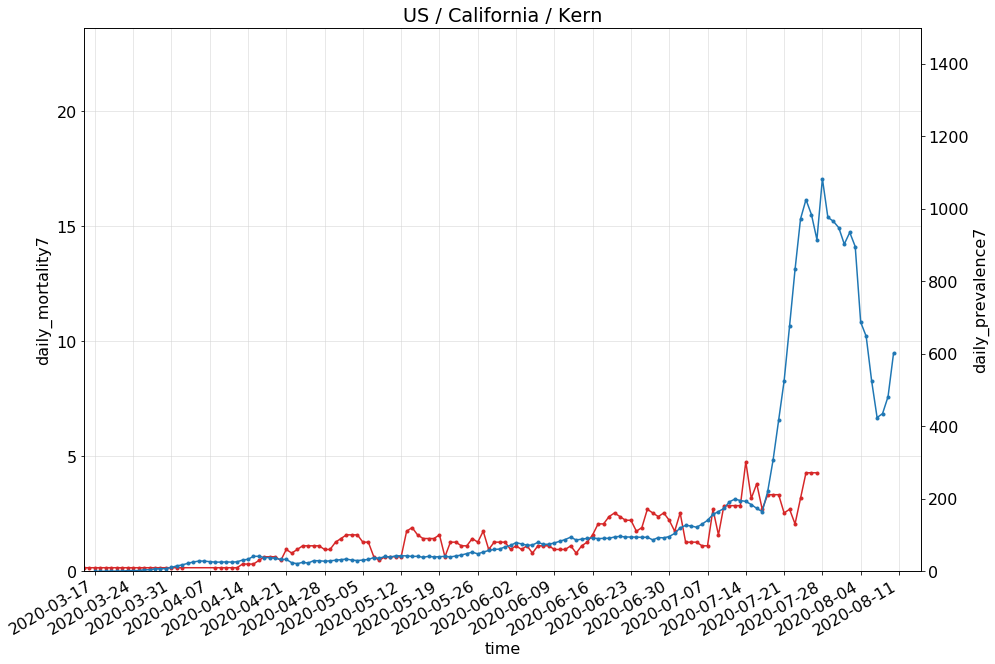

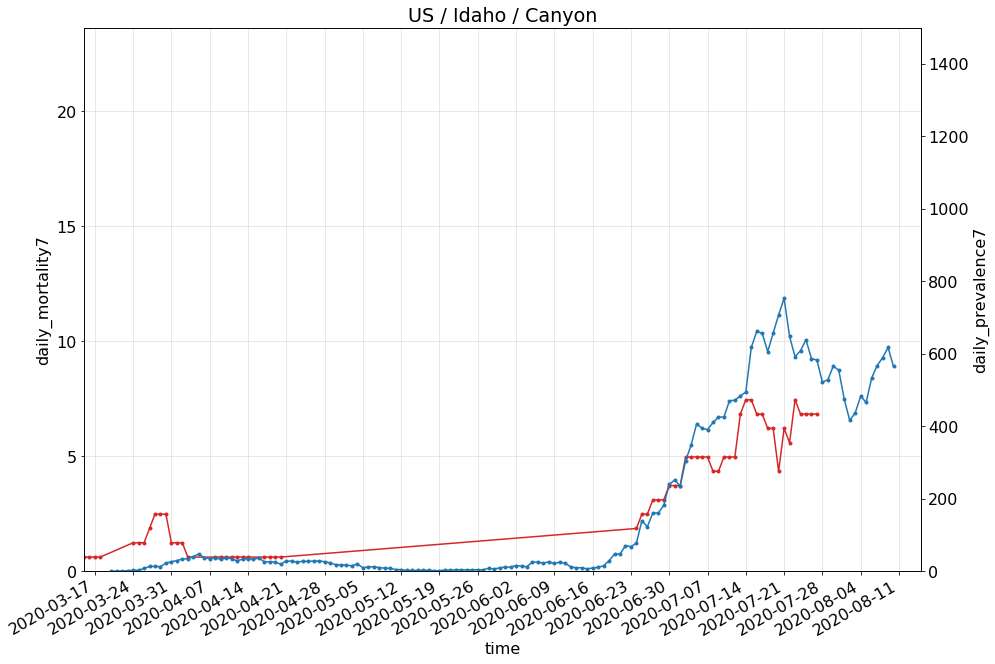

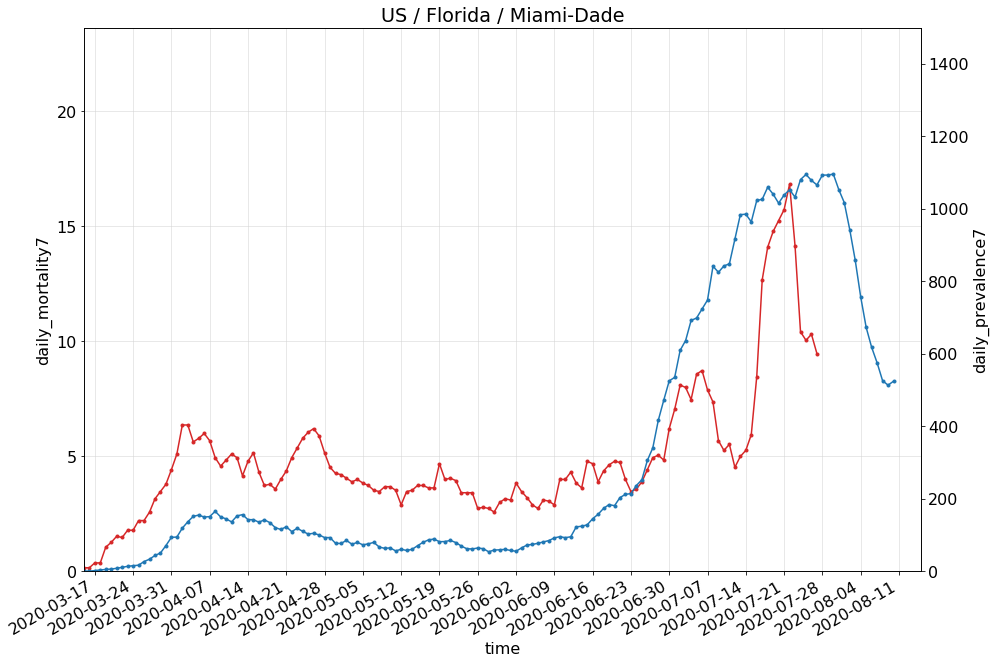

In [31]:
tmp = ds_counties.sortby(-ds_counties['daily_prevalence7'].isel(time=-1))
for location in list(tmp.sel(location=tmp['population'] > 100_000).location.values)[:10]:
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    ds = ds_counties.sel(location=location)

    ax2 = ax1.twinx()
    
    covid19.plot.plot_data(ax1, ds['daily_mortality7'], color=PALETTE_ONE[3], delay=-14)
    covid19.plot.plot_data(ax2, ds['daily_prevalence7'], color=PALETTE_ONE[0])

    ax1.set(ylim=(0, 1500. * 0.01575), title=location)
    ax2.set(ylim=(0, 1500.), title=None)

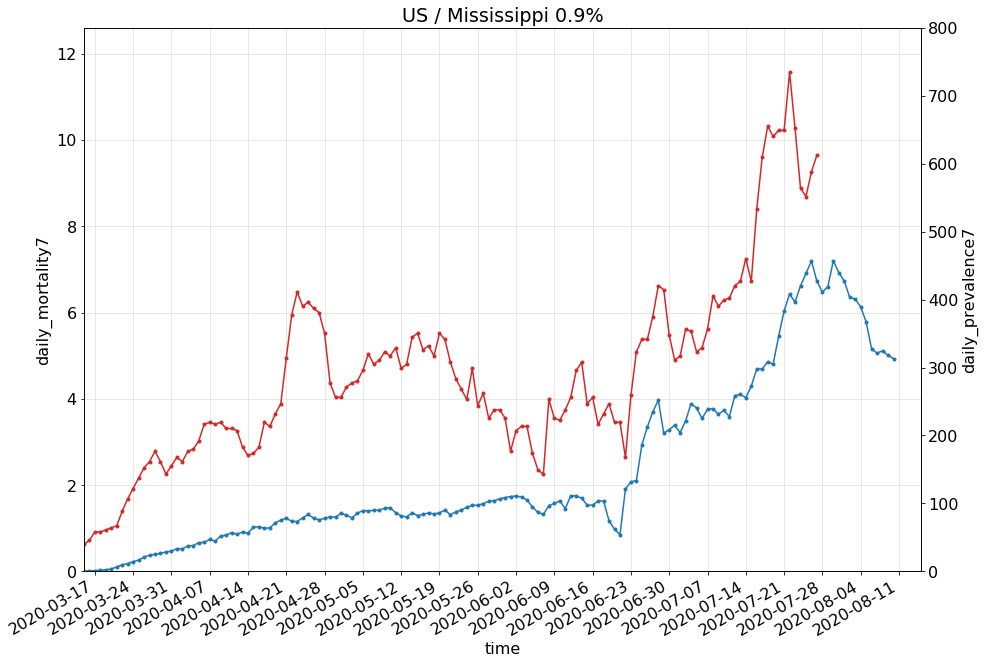

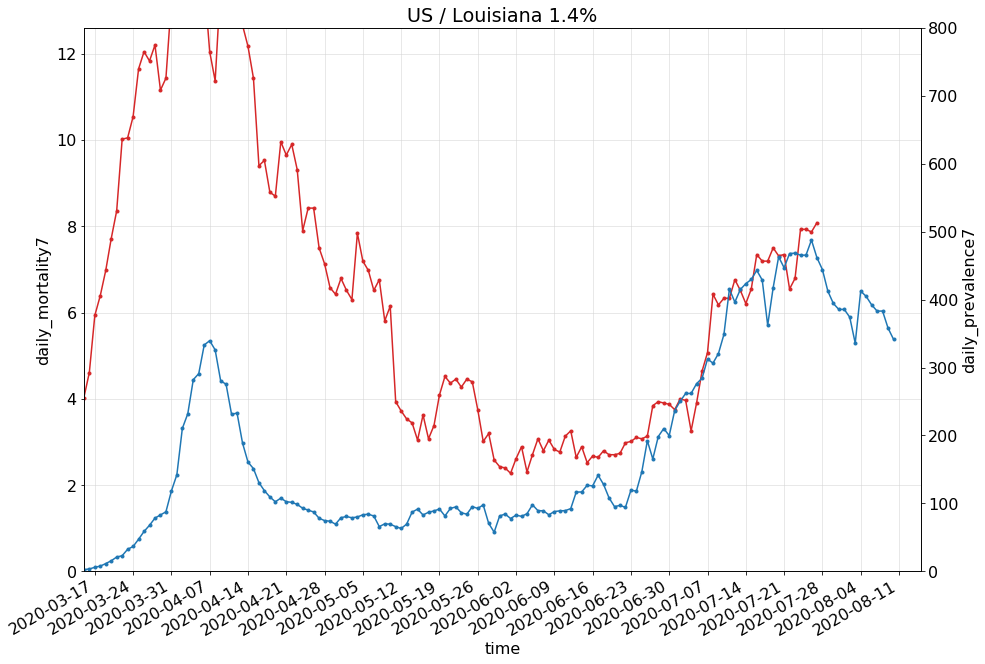

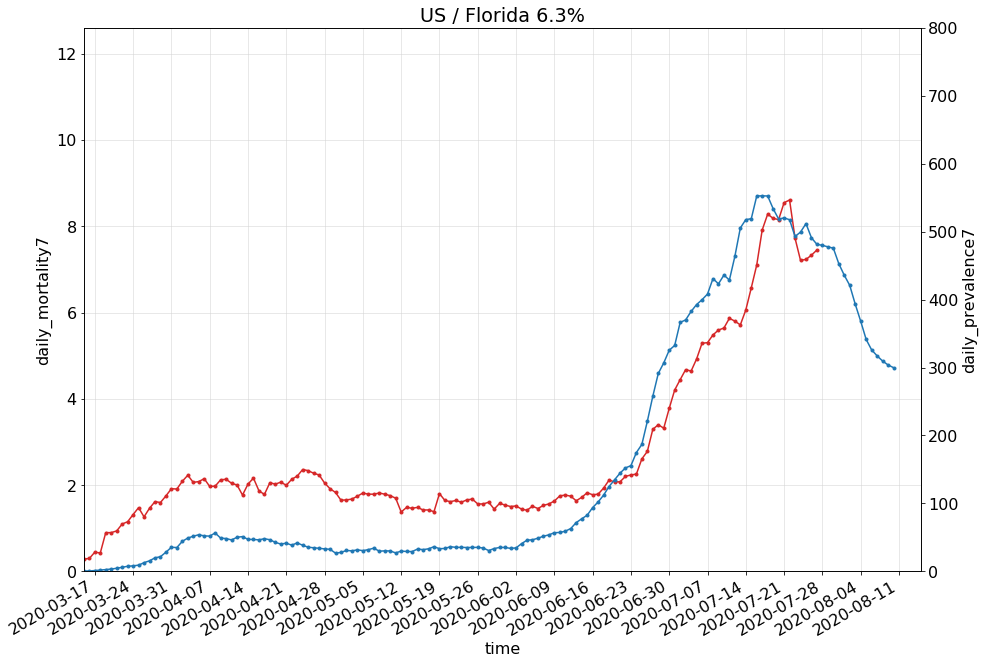

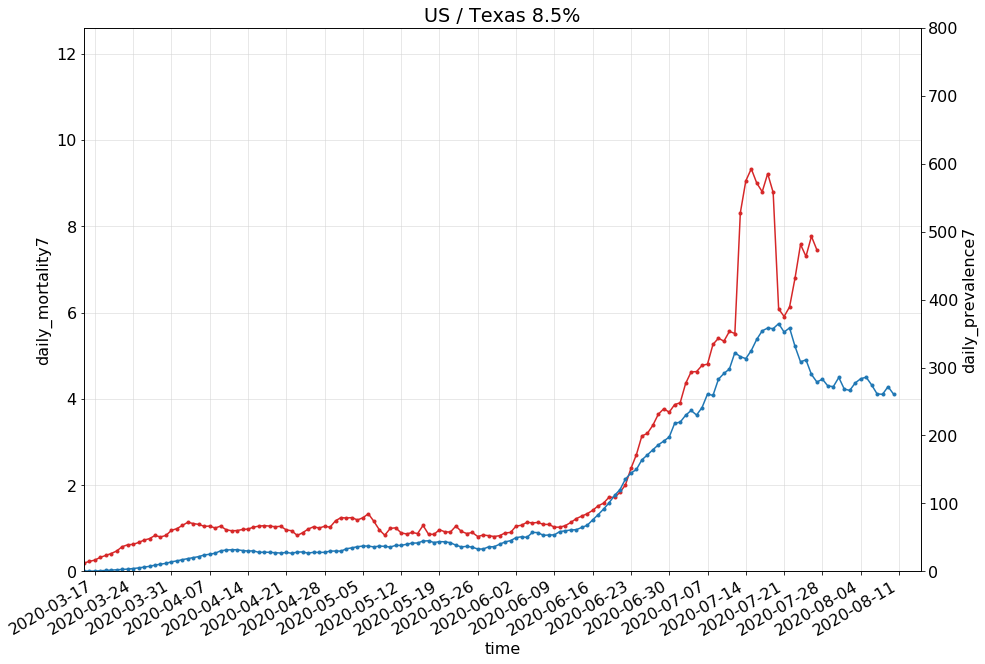

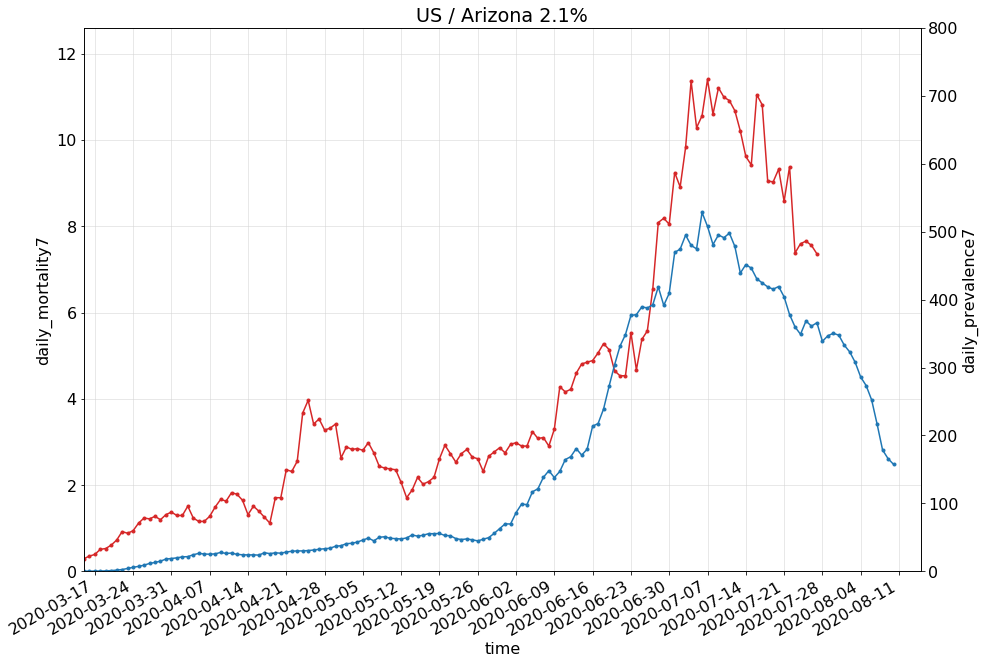

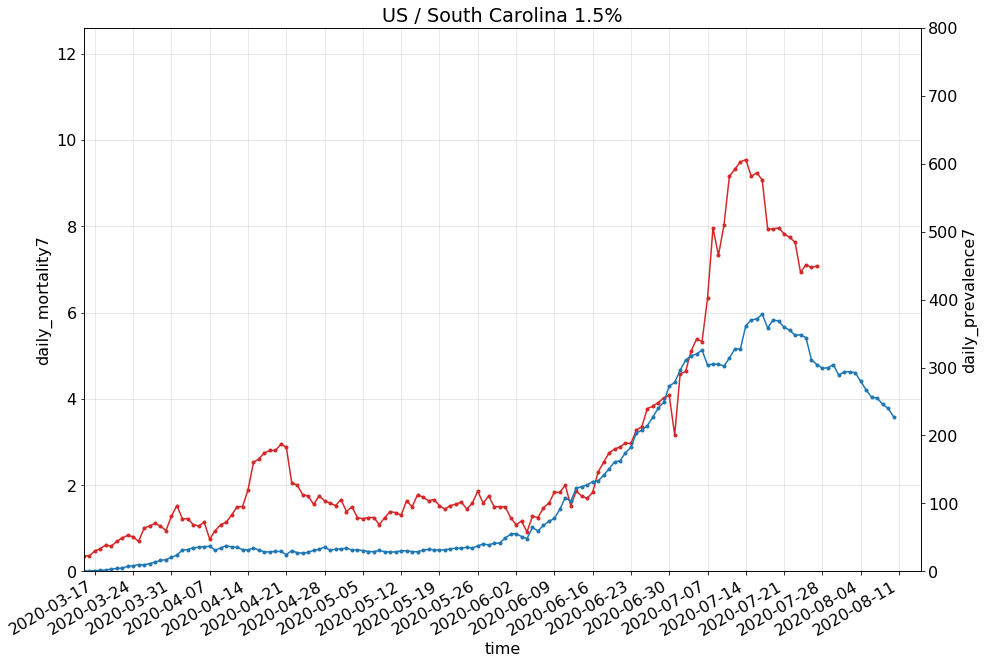

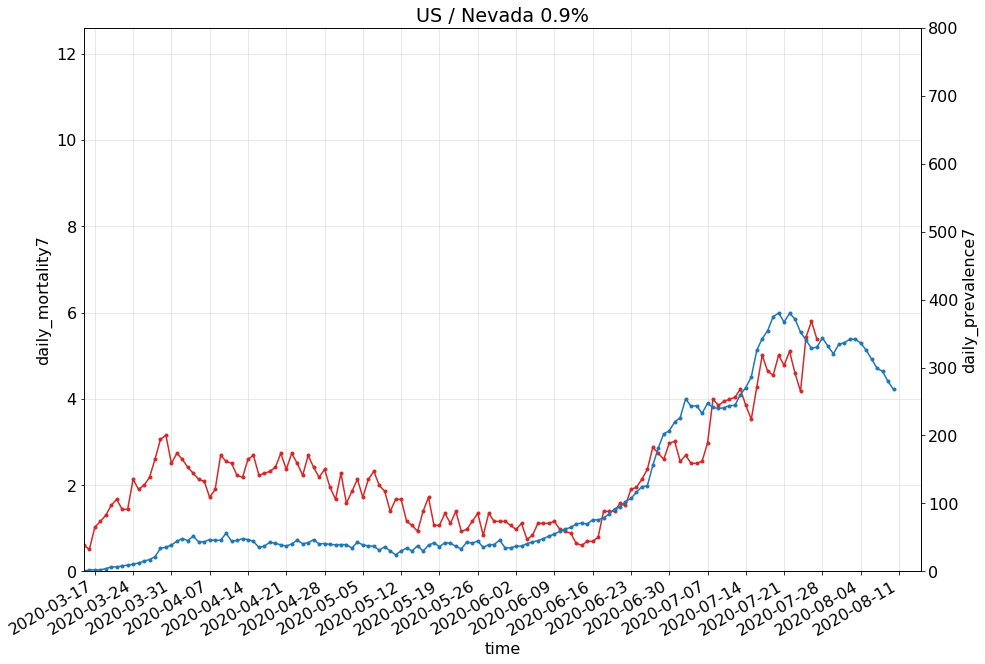

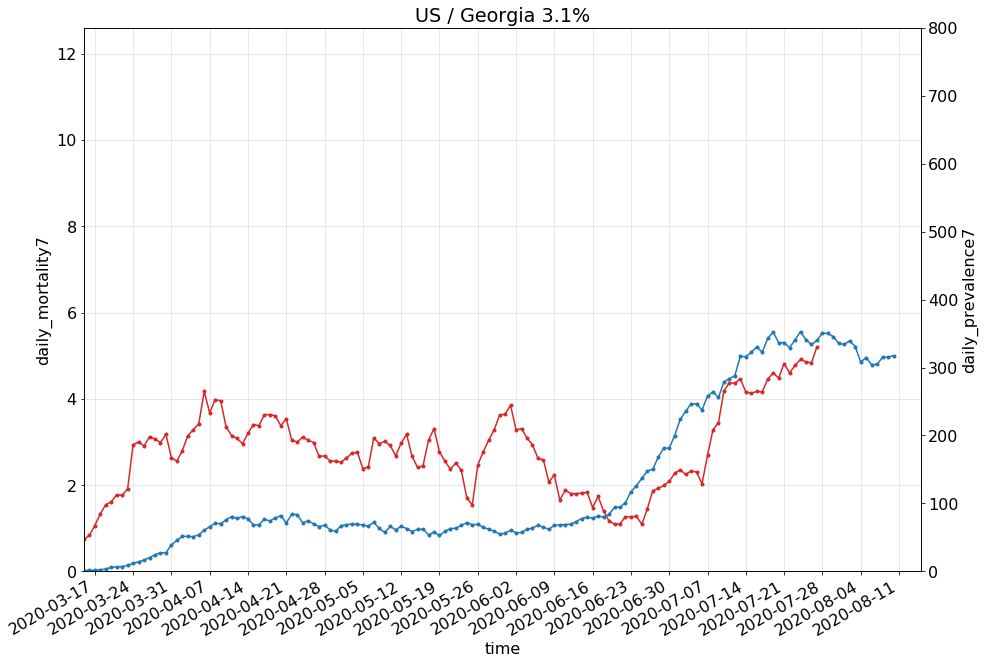

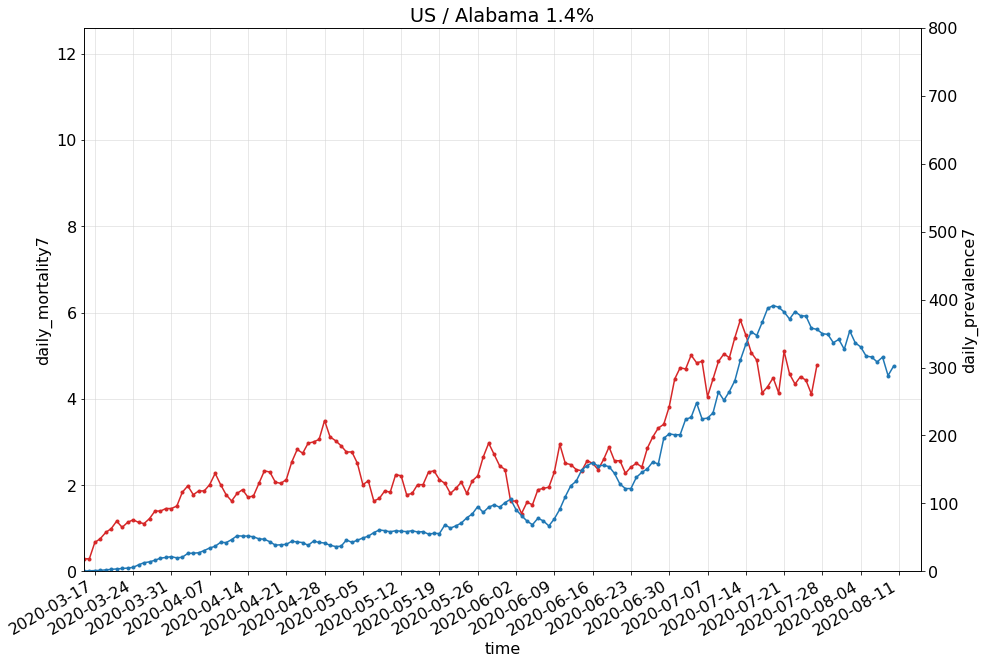

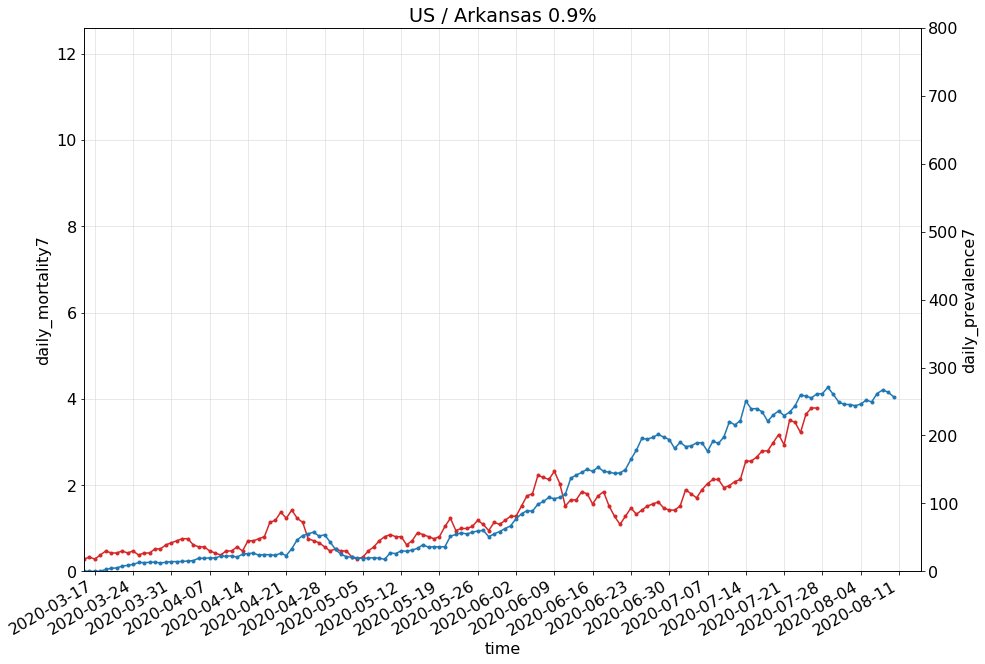

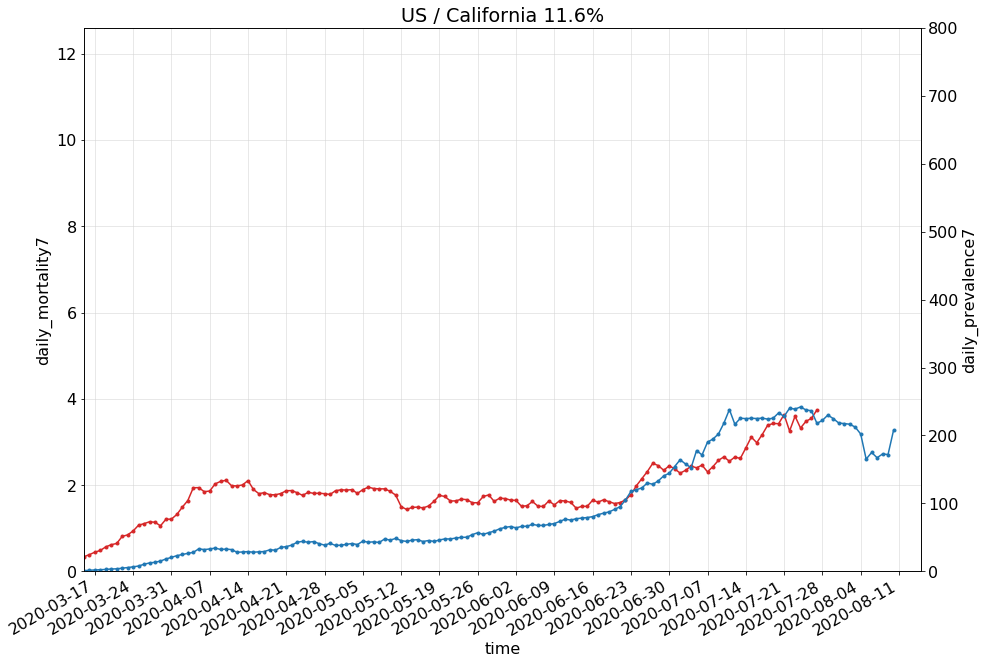

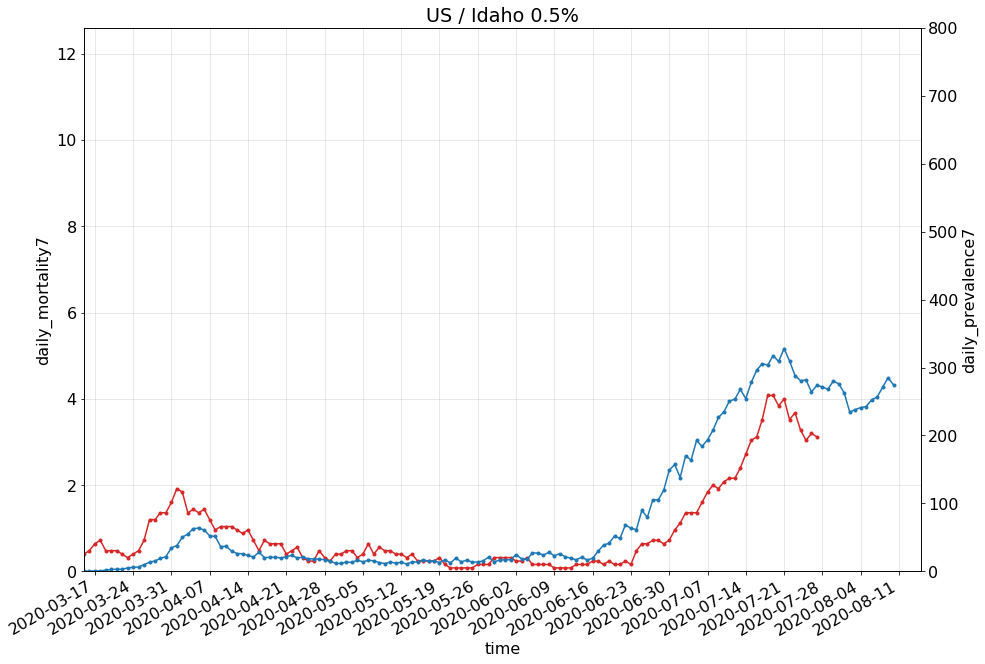

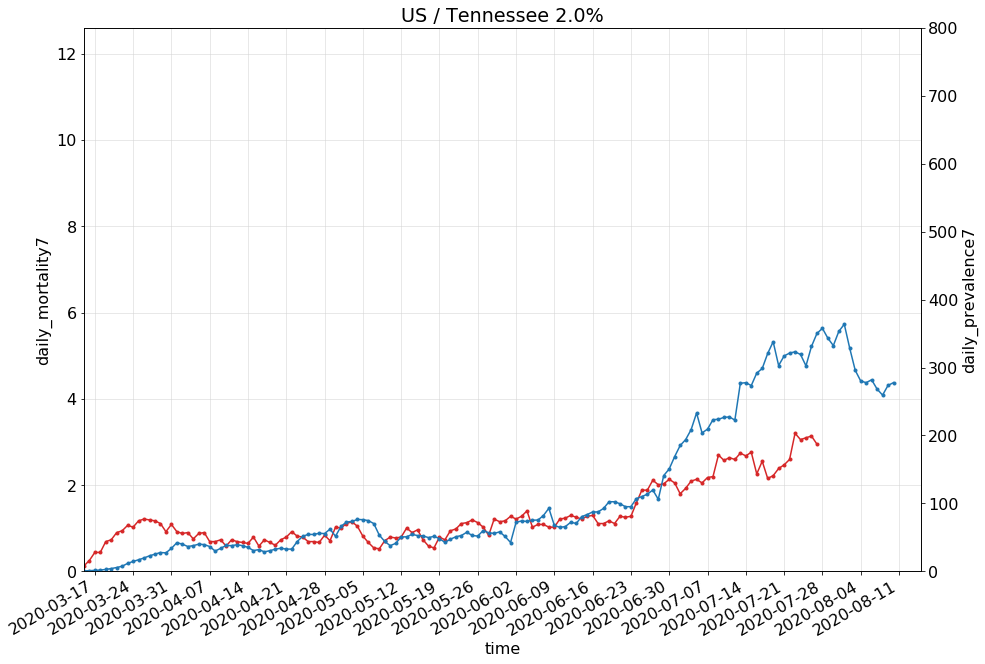

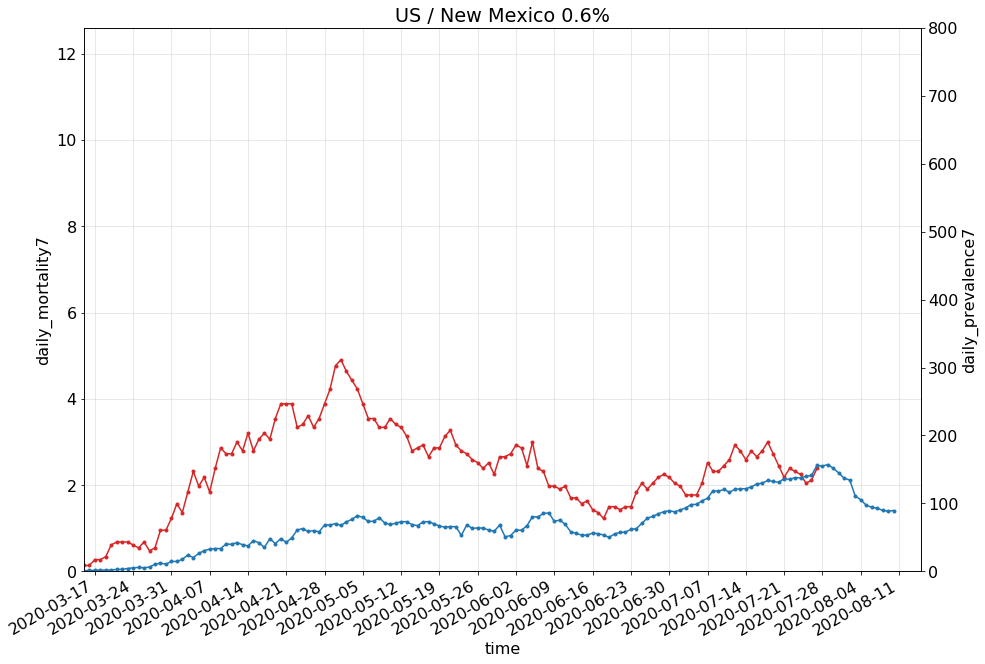

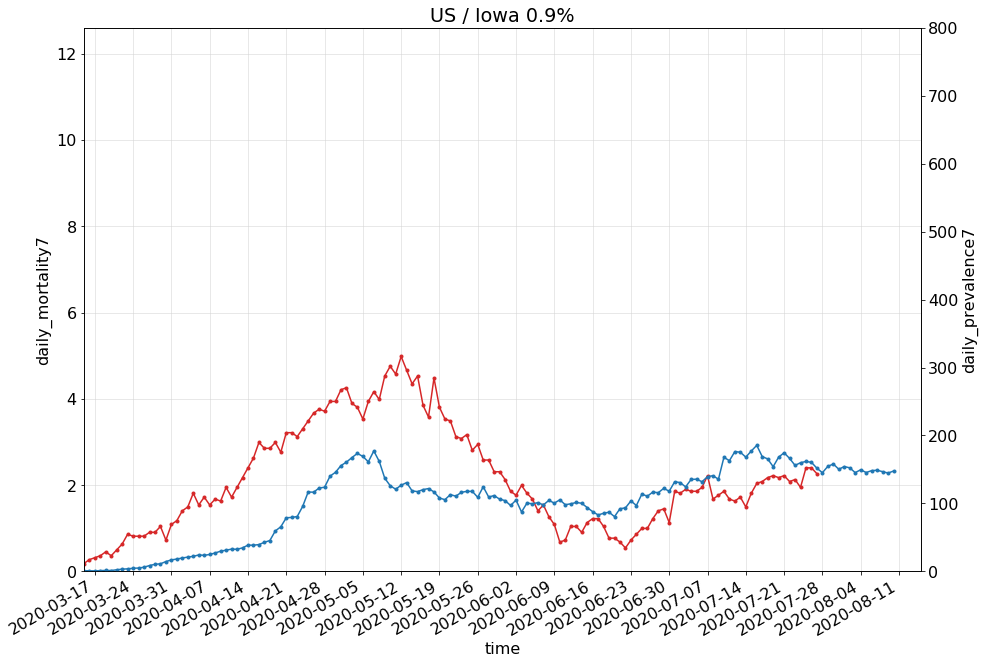

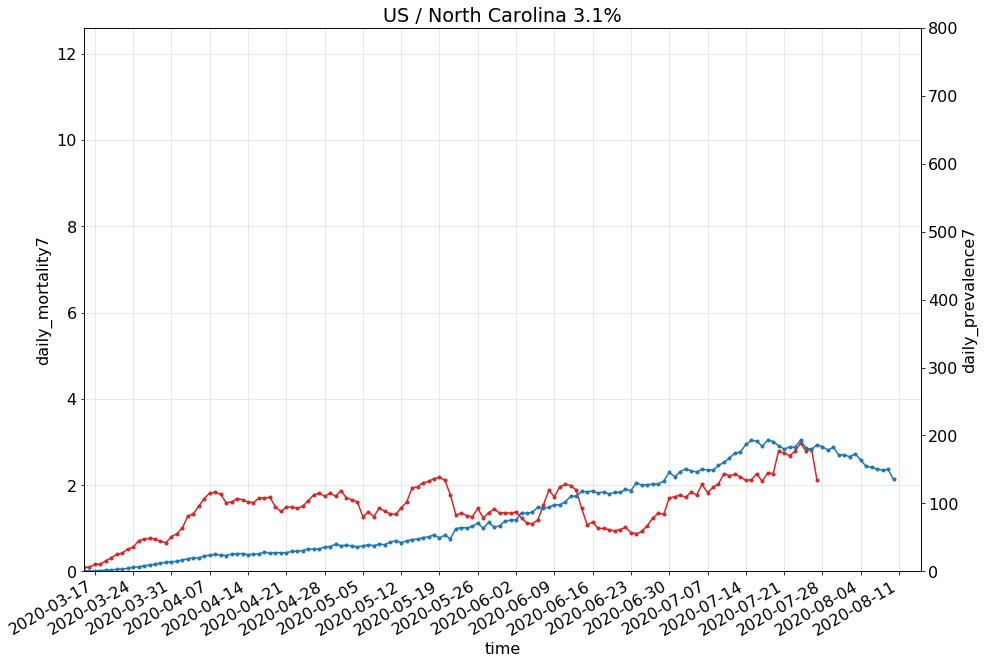

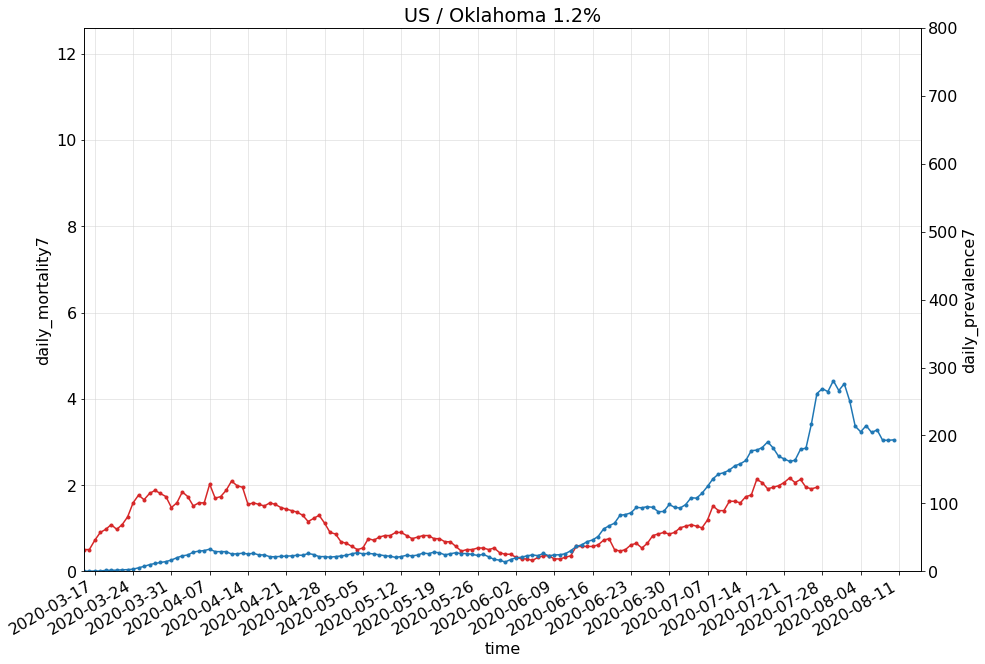

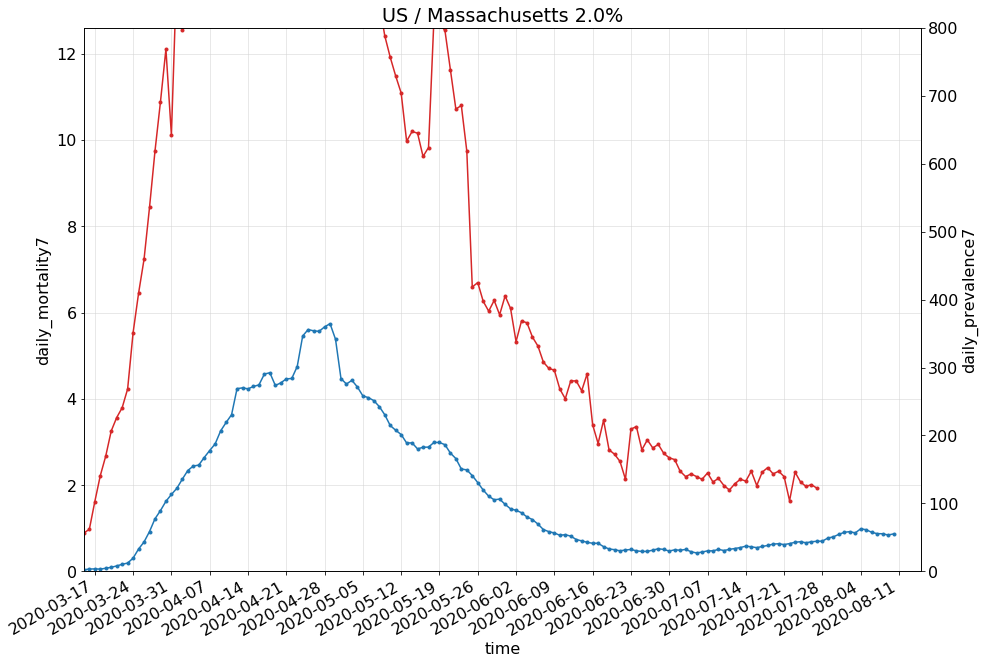

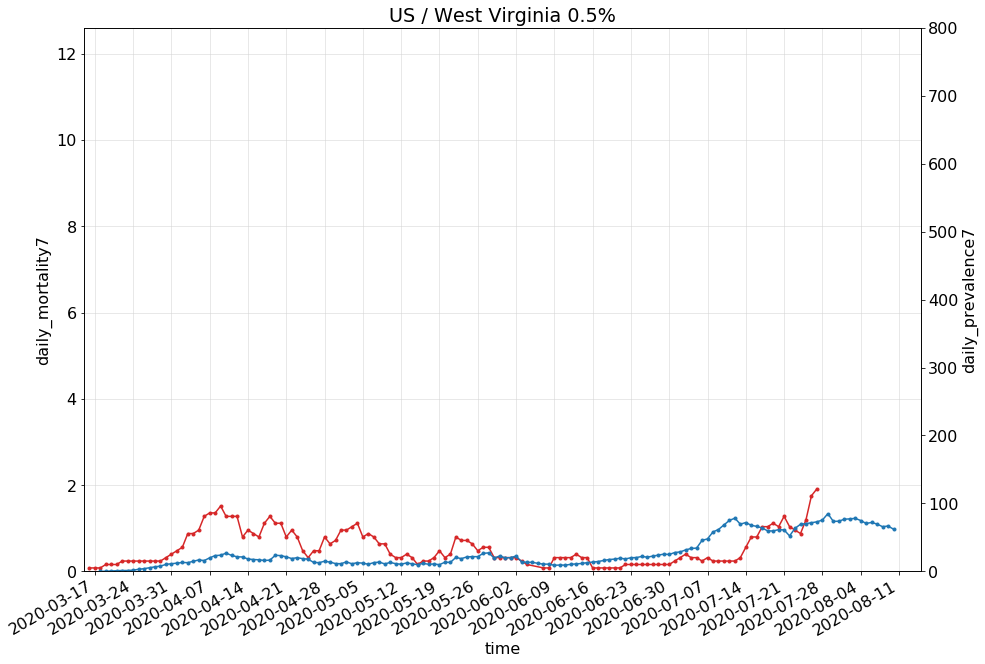

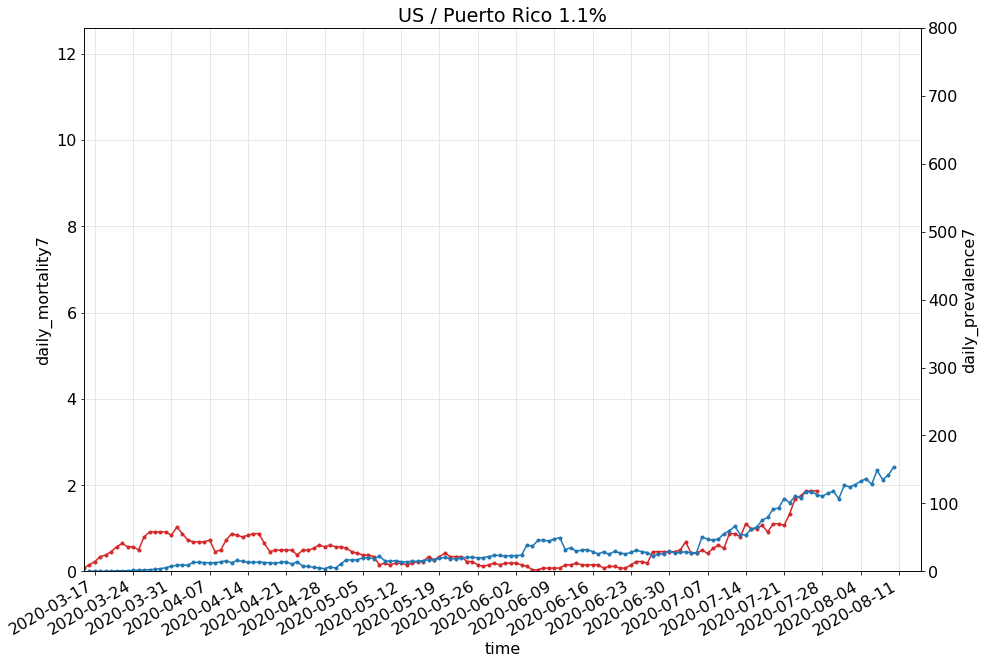

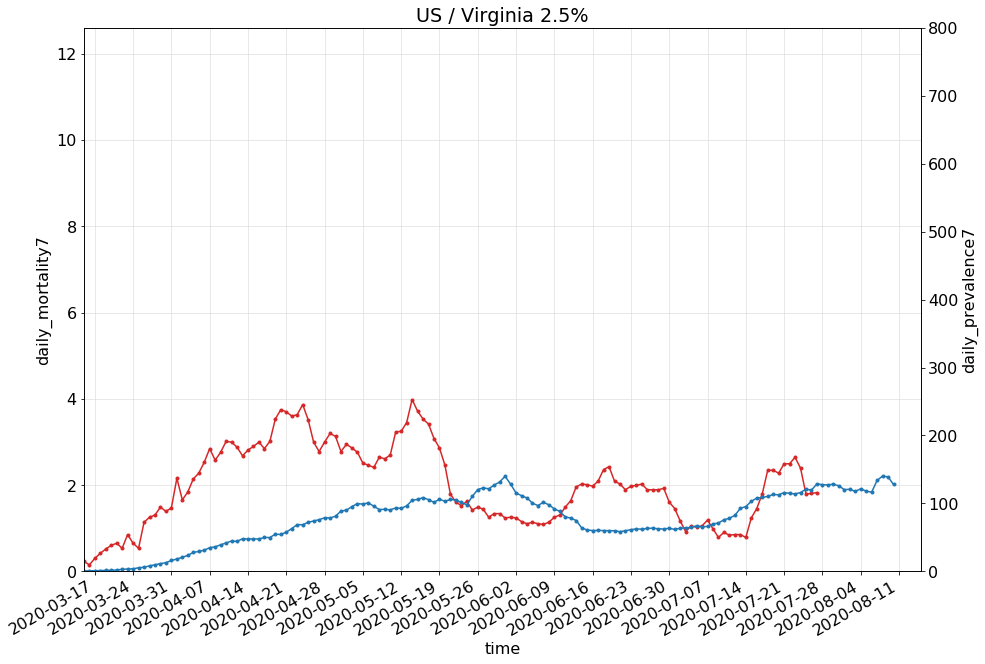

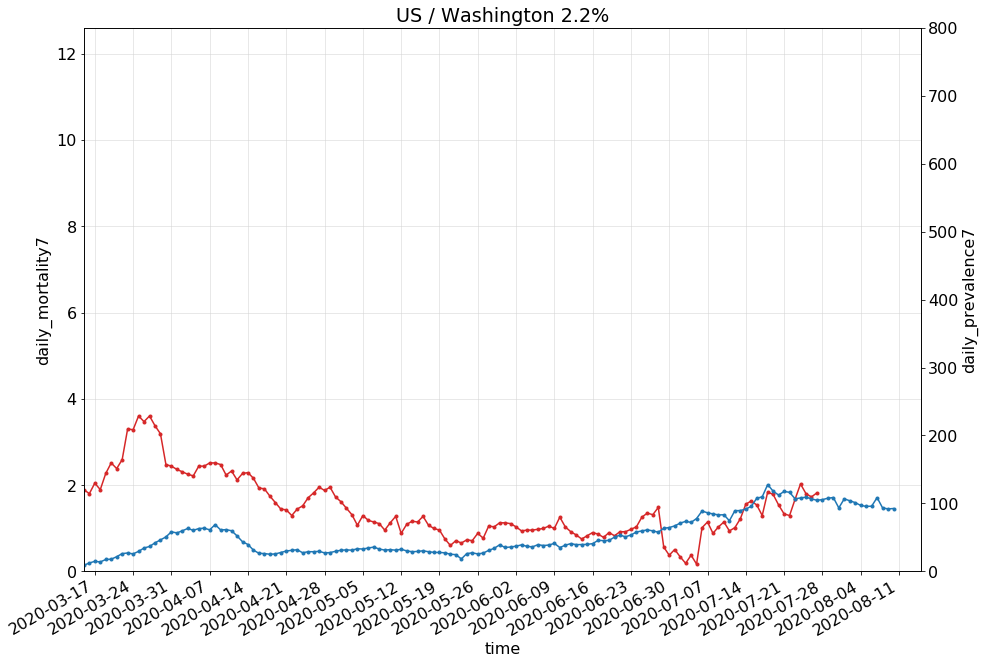

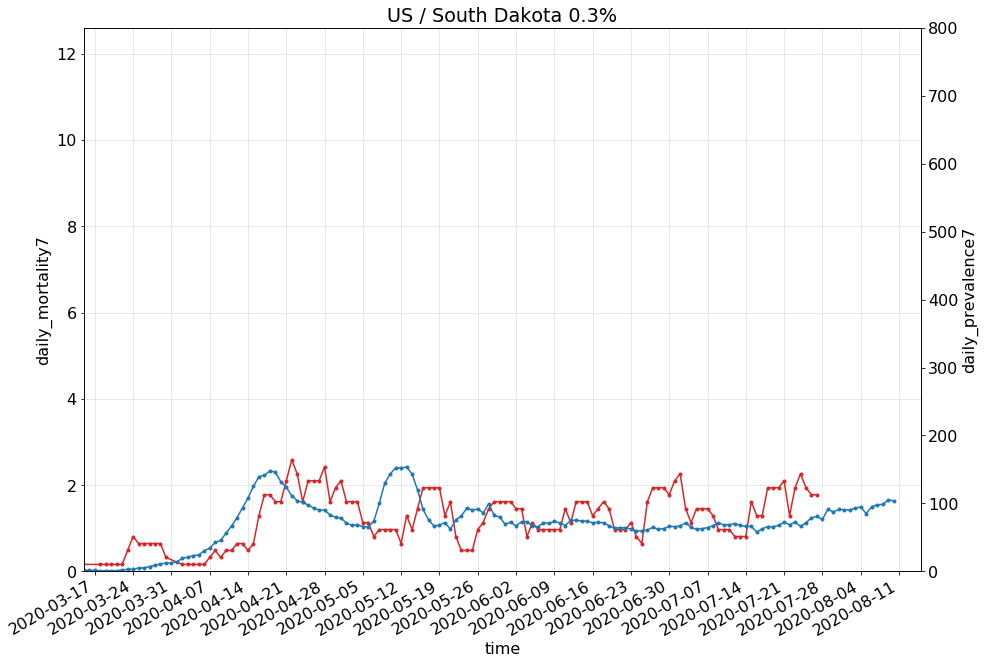

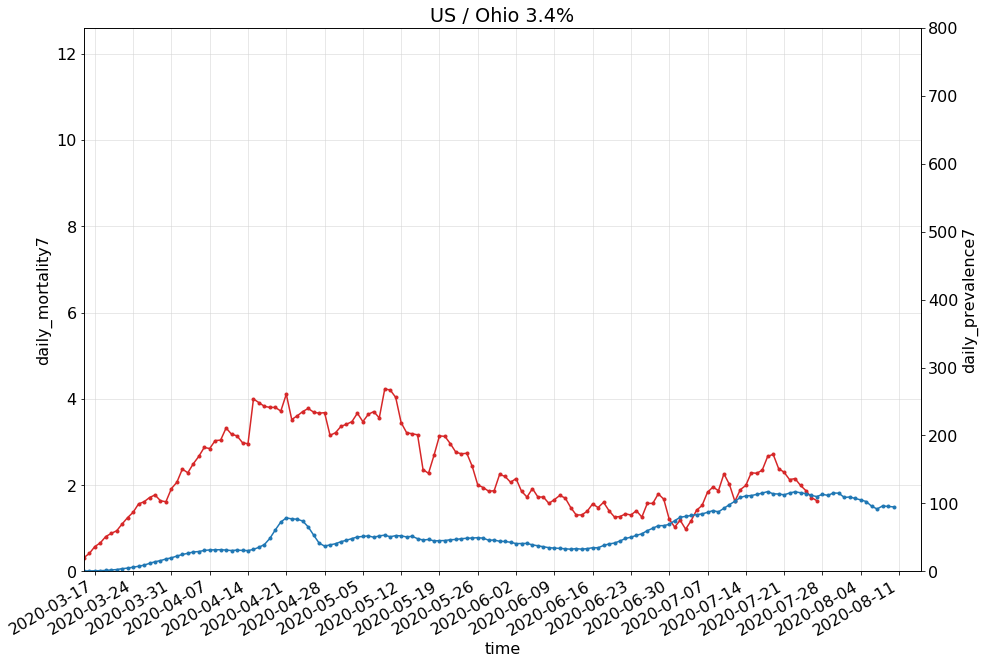

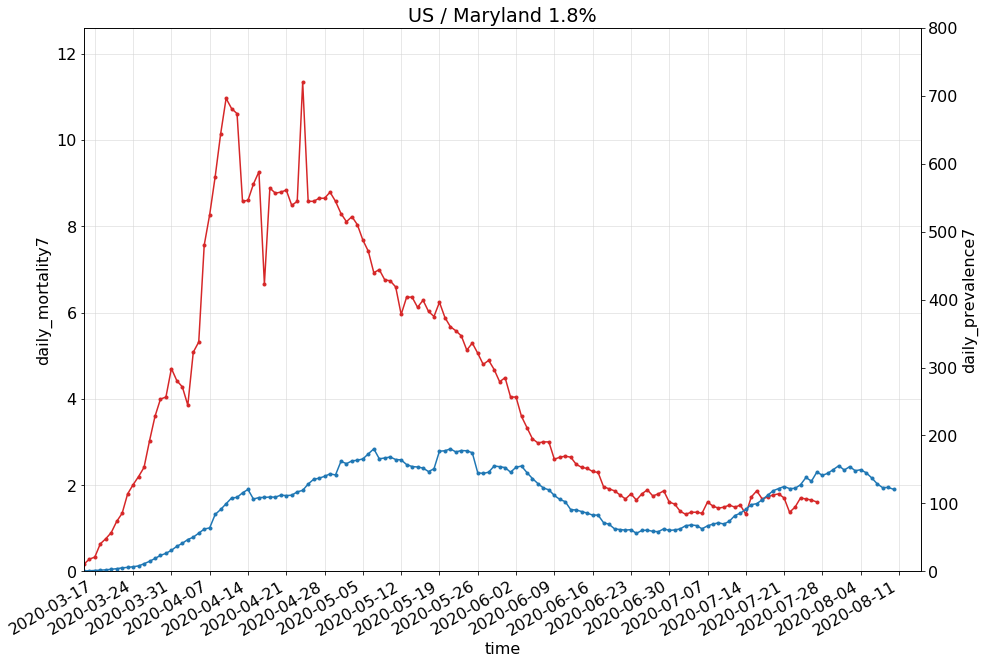

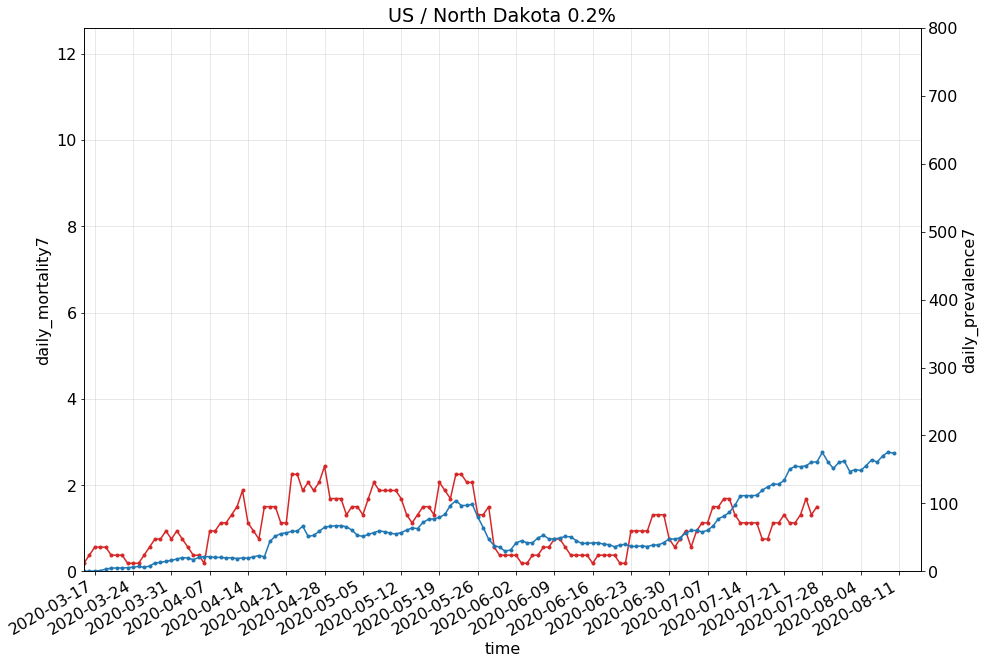

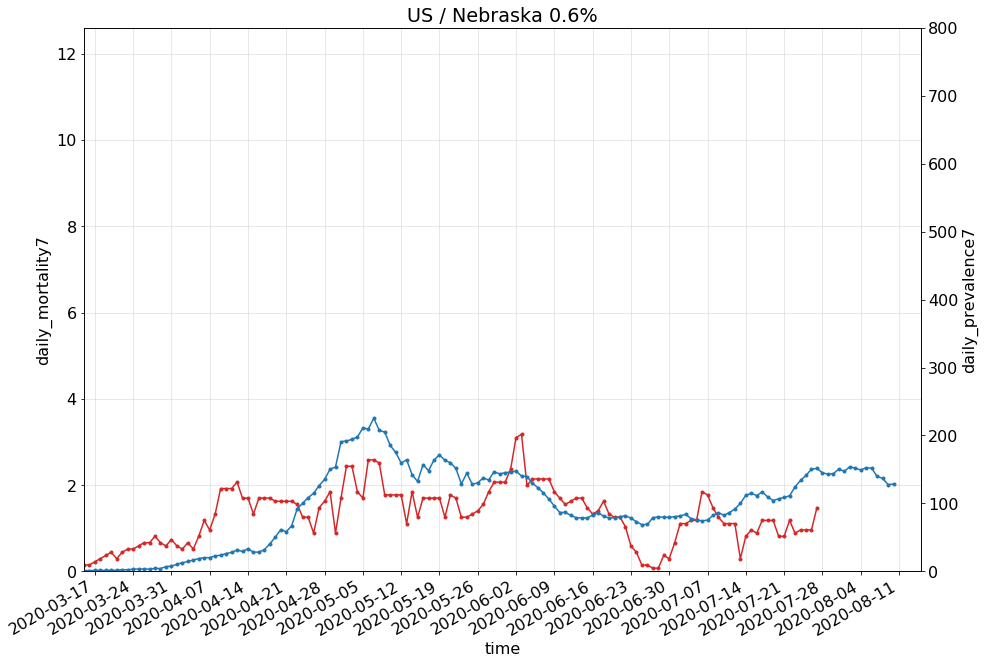

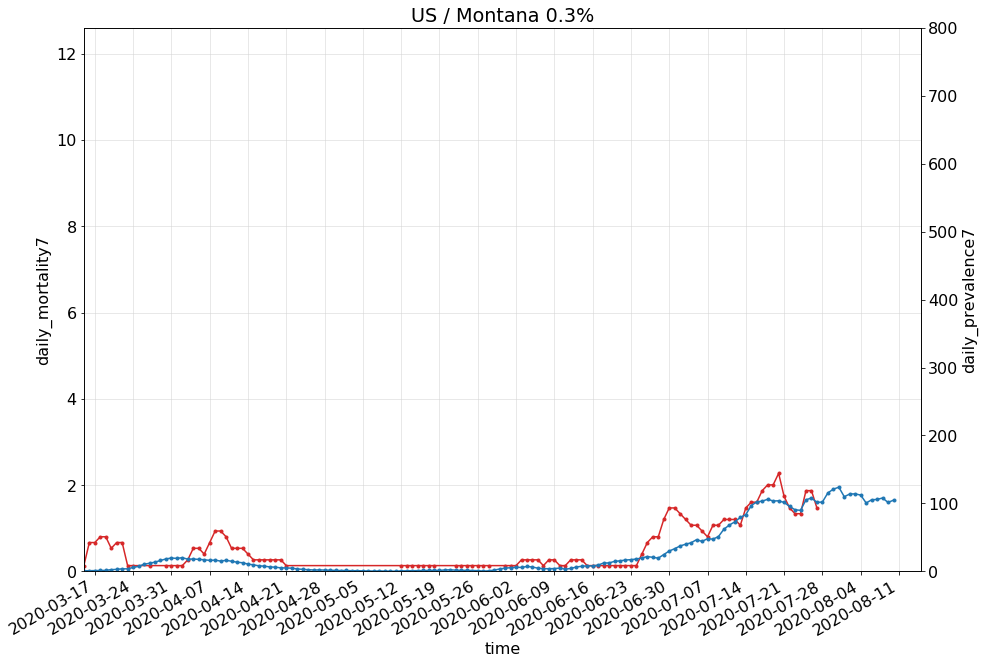

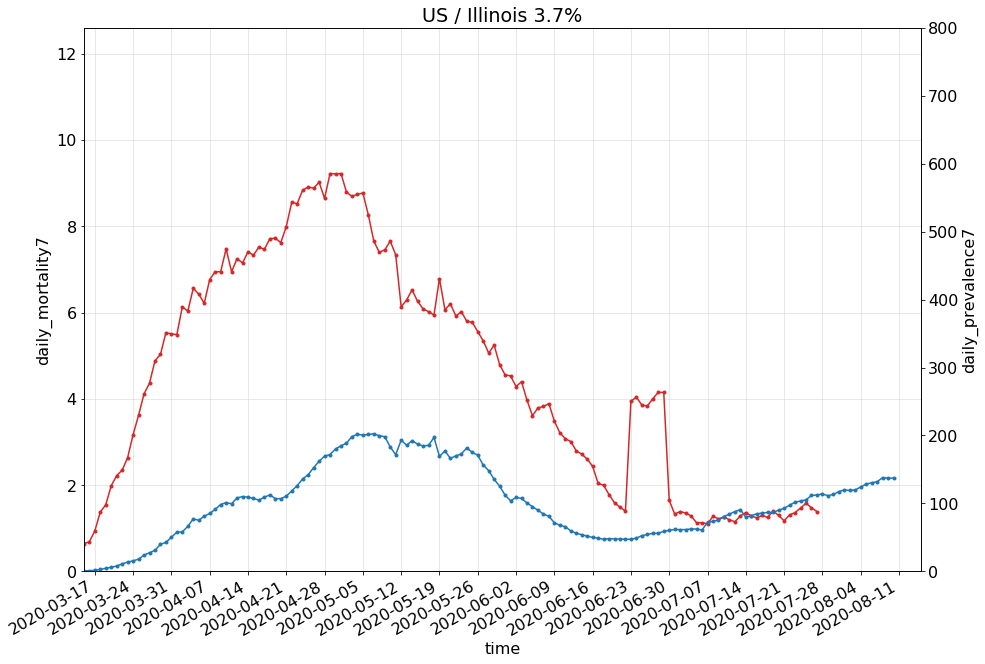

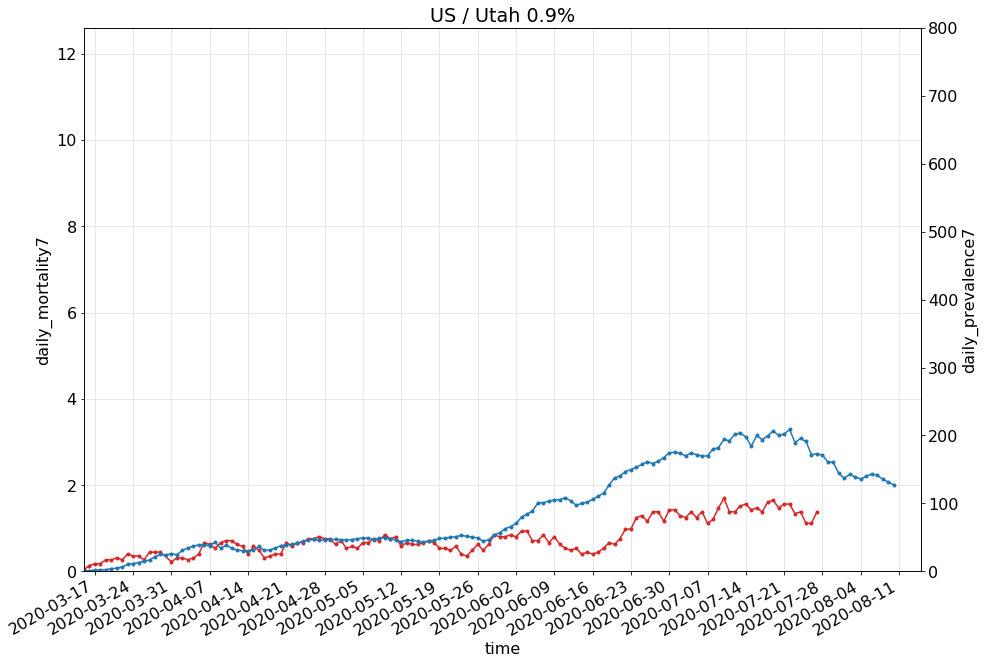

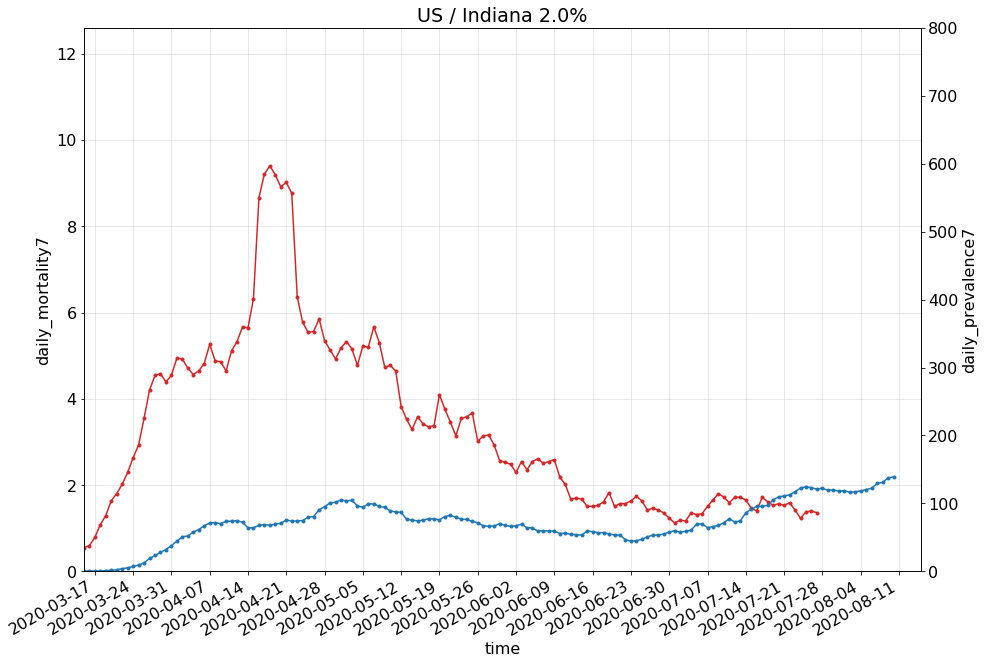

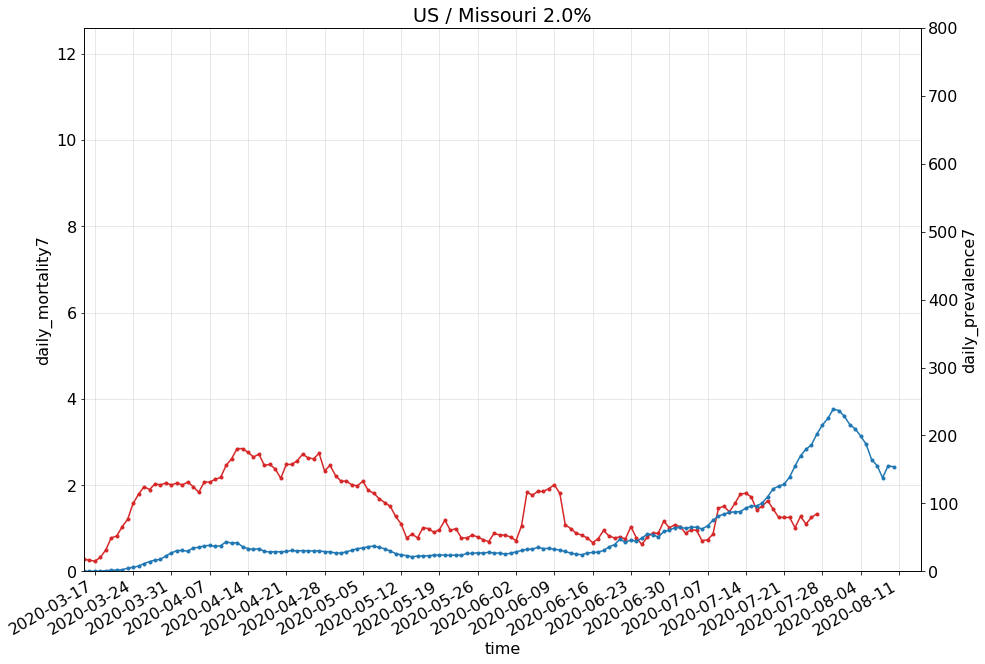

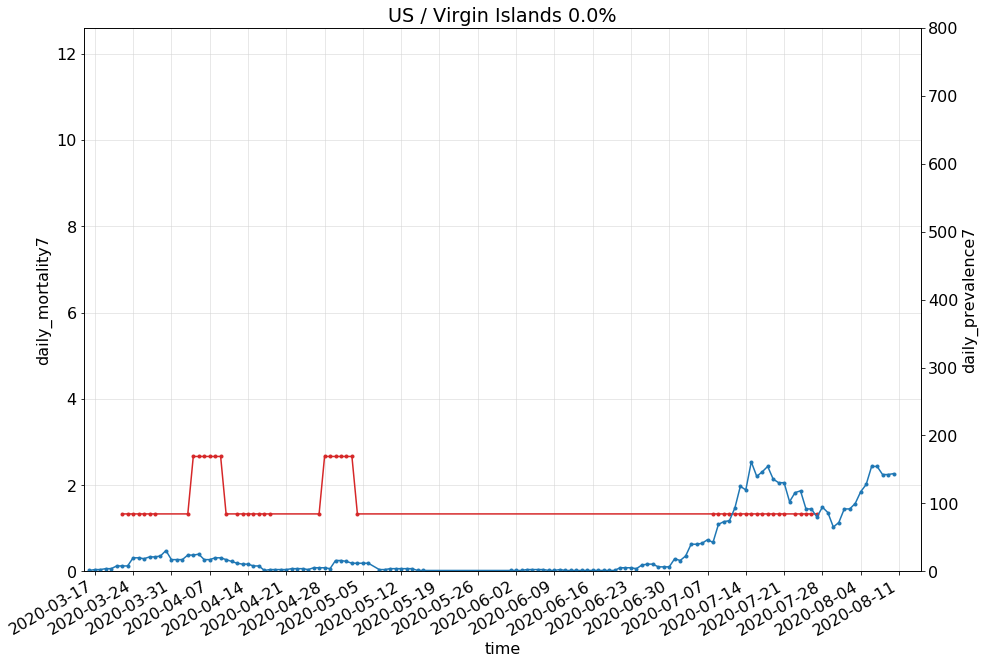

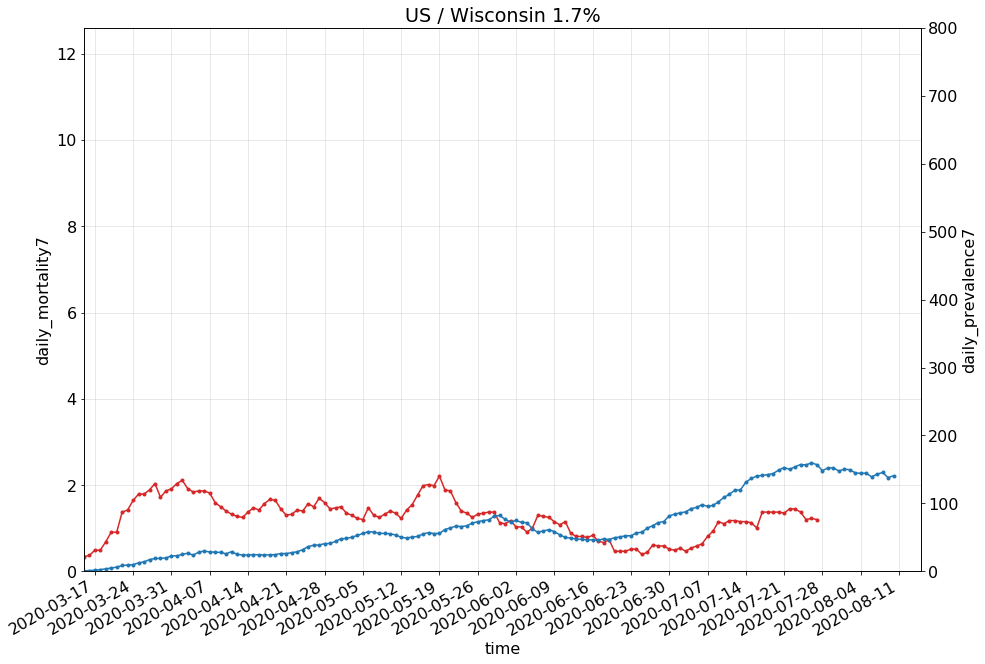

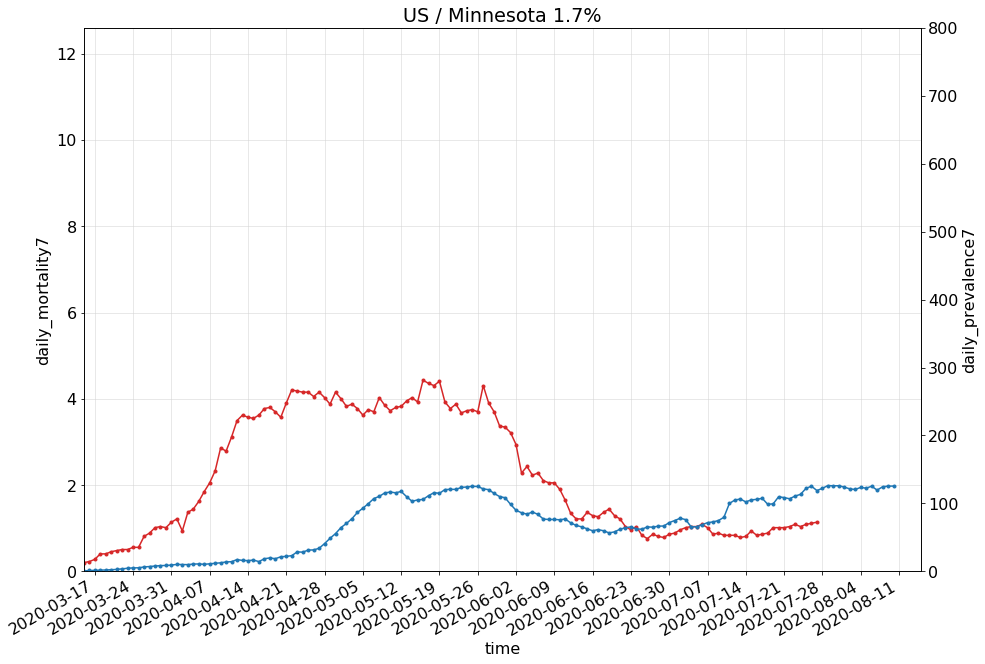

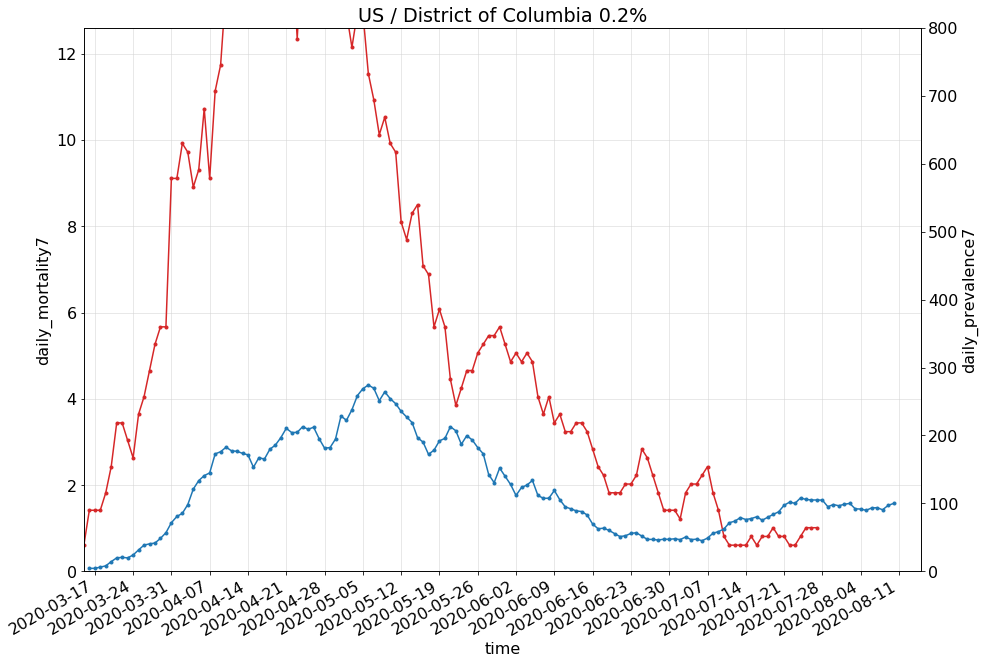

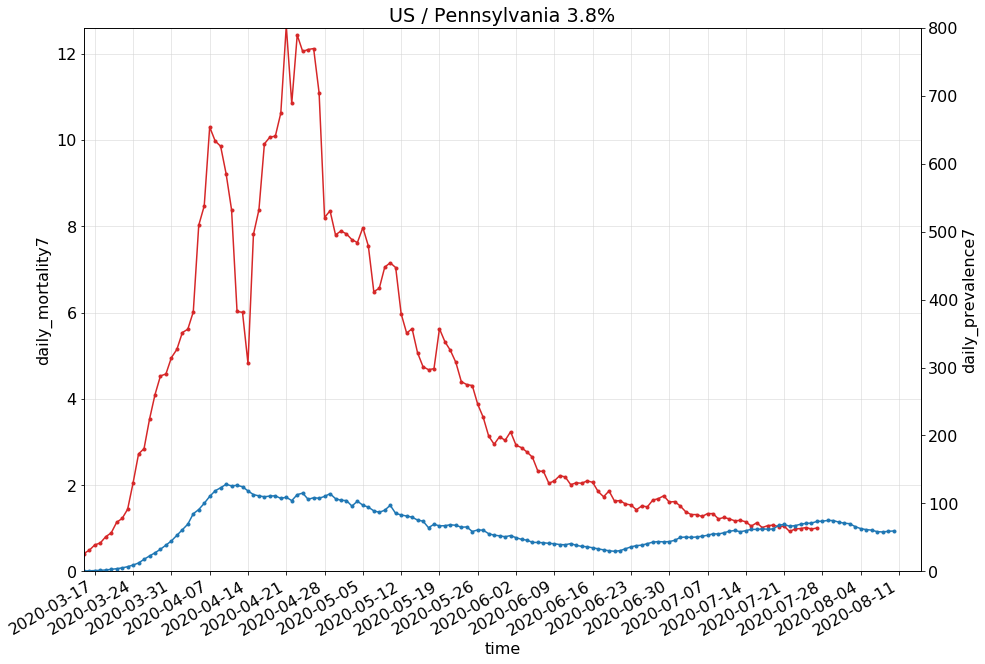

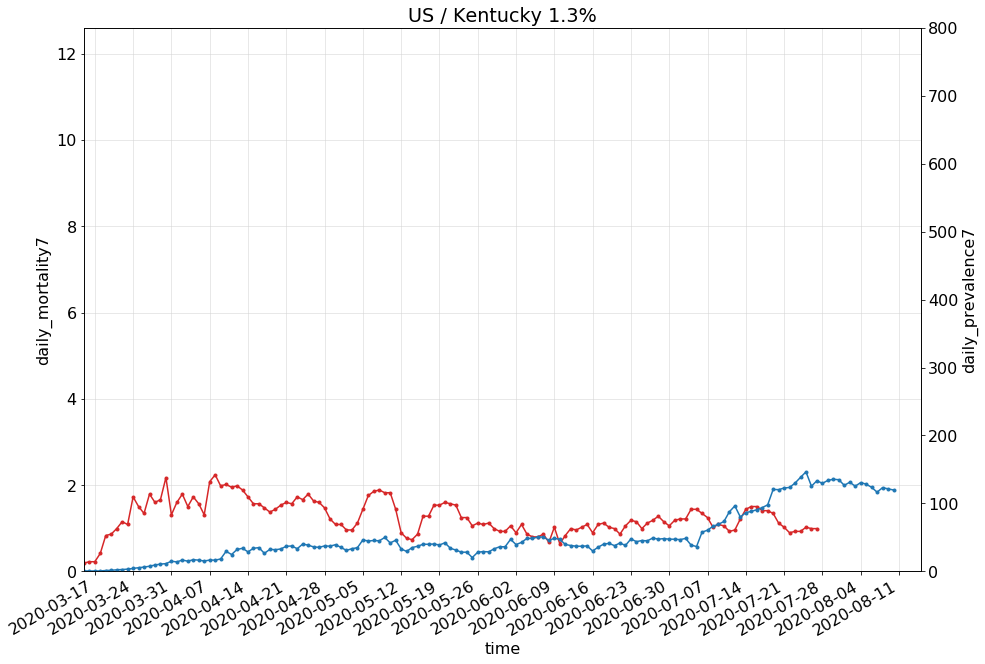

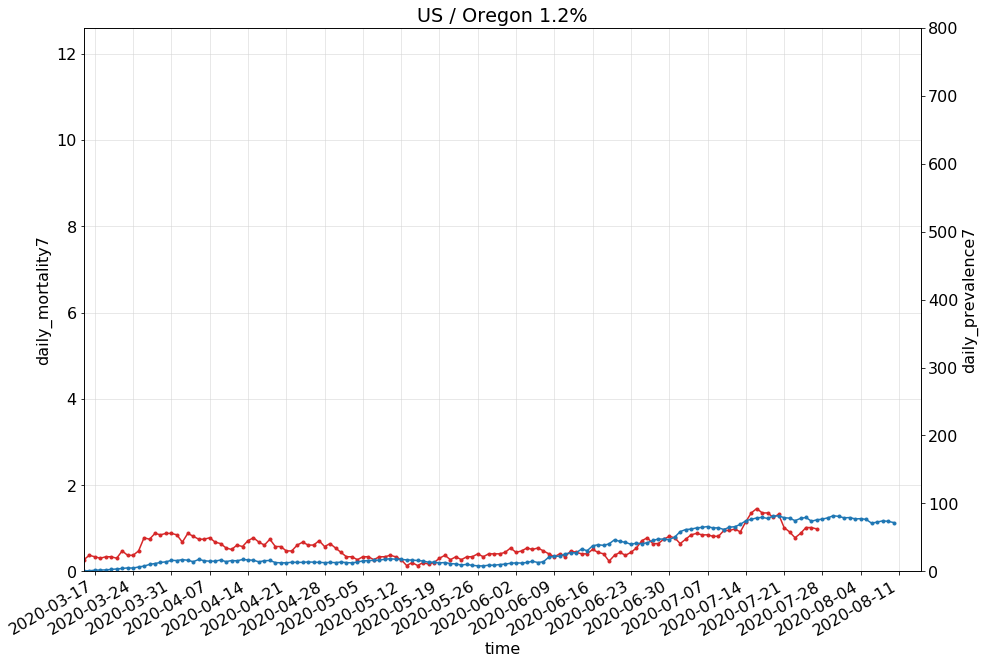

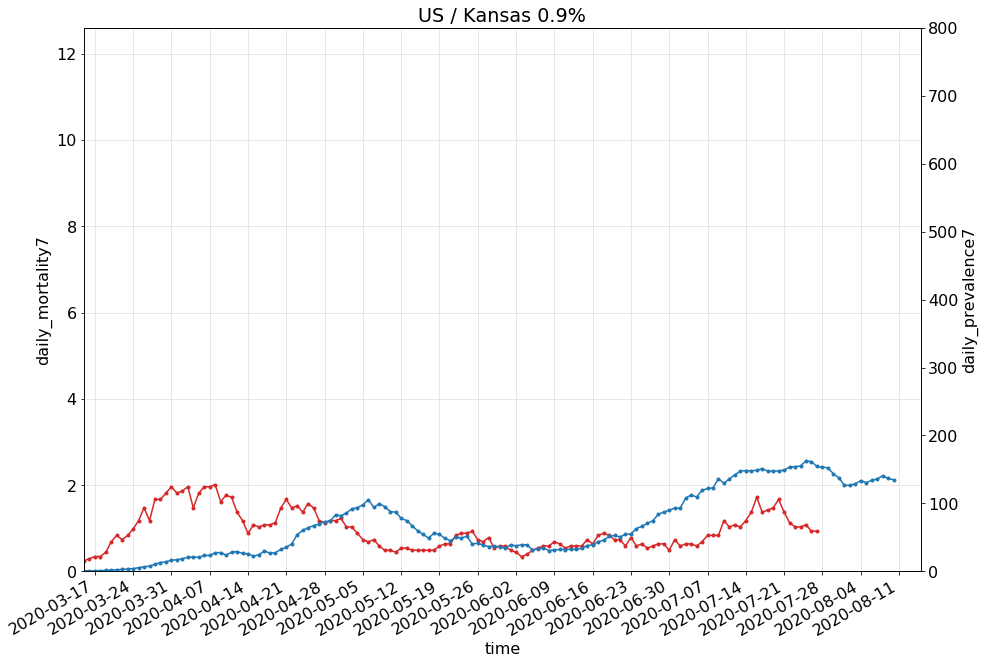

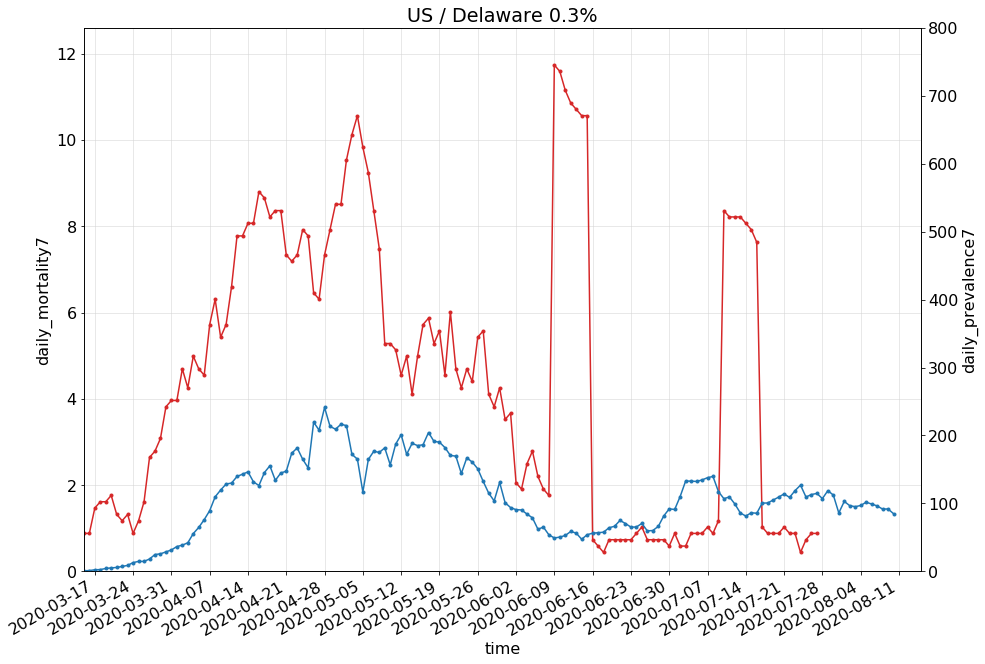

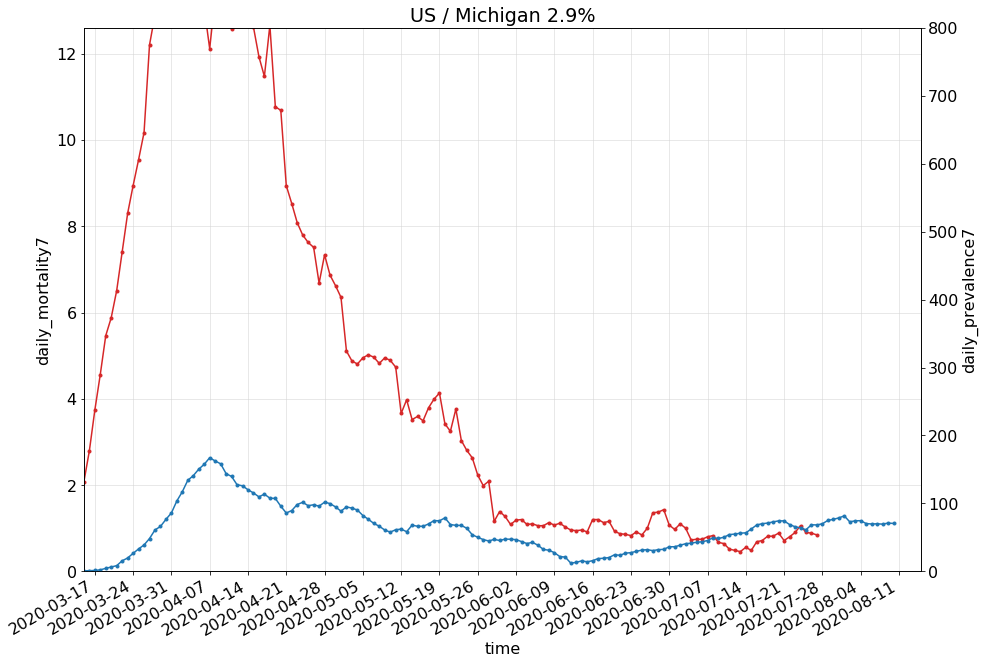

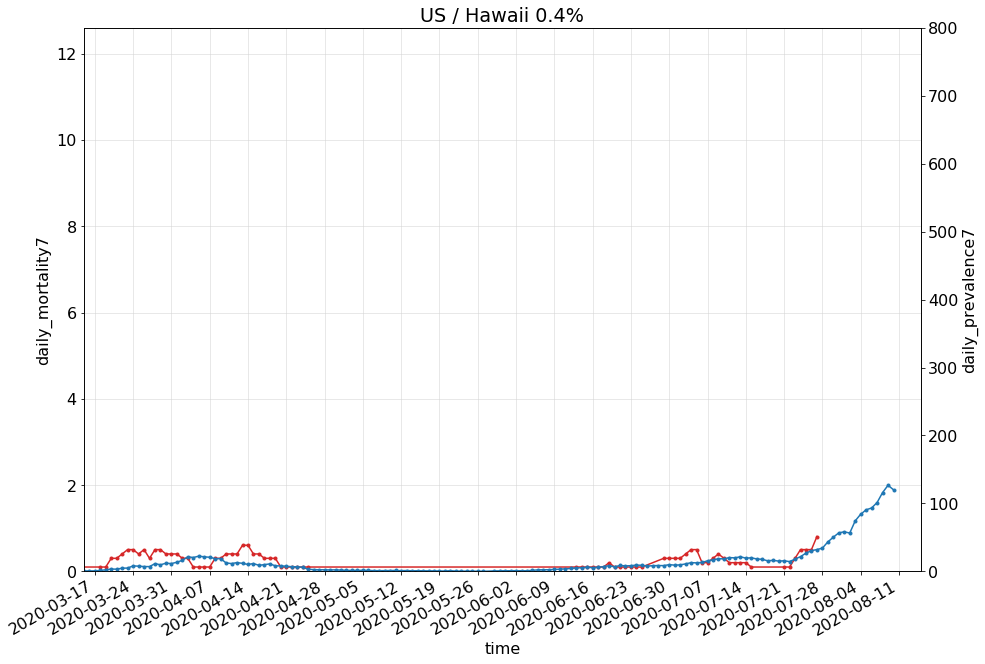

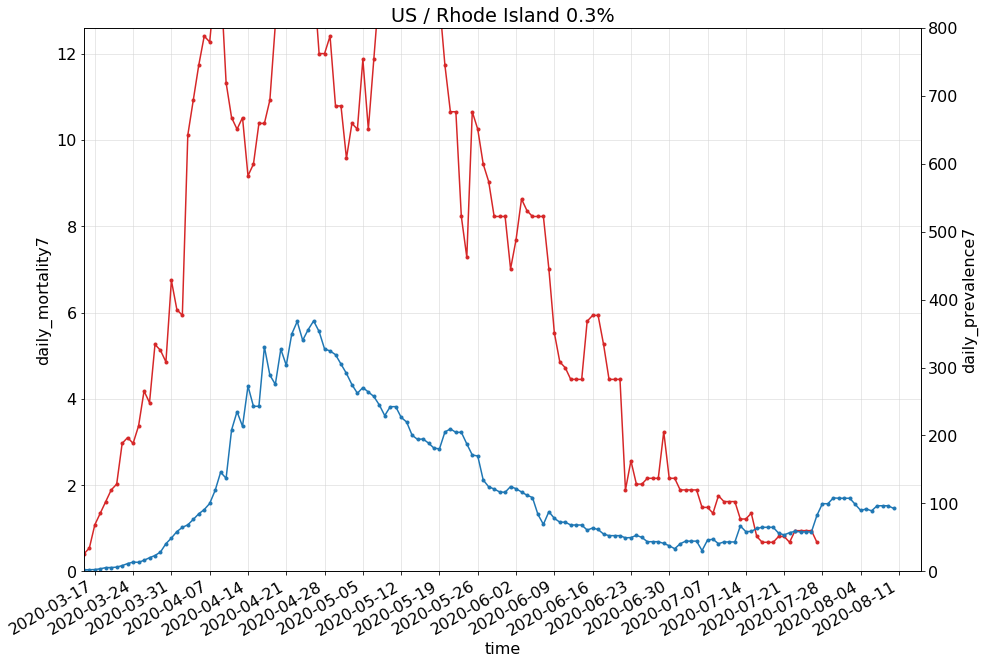

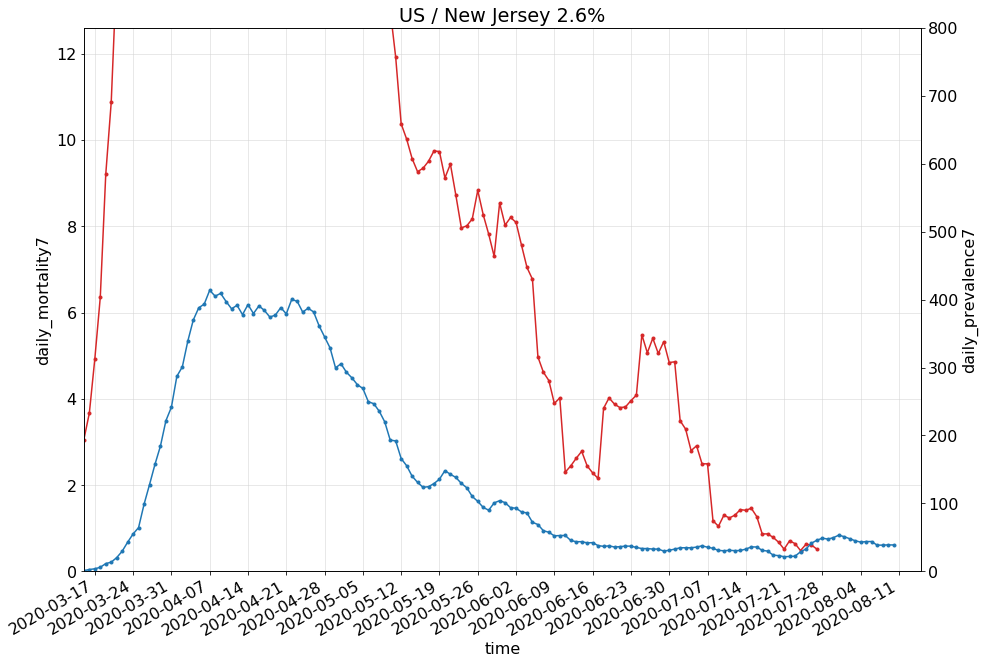

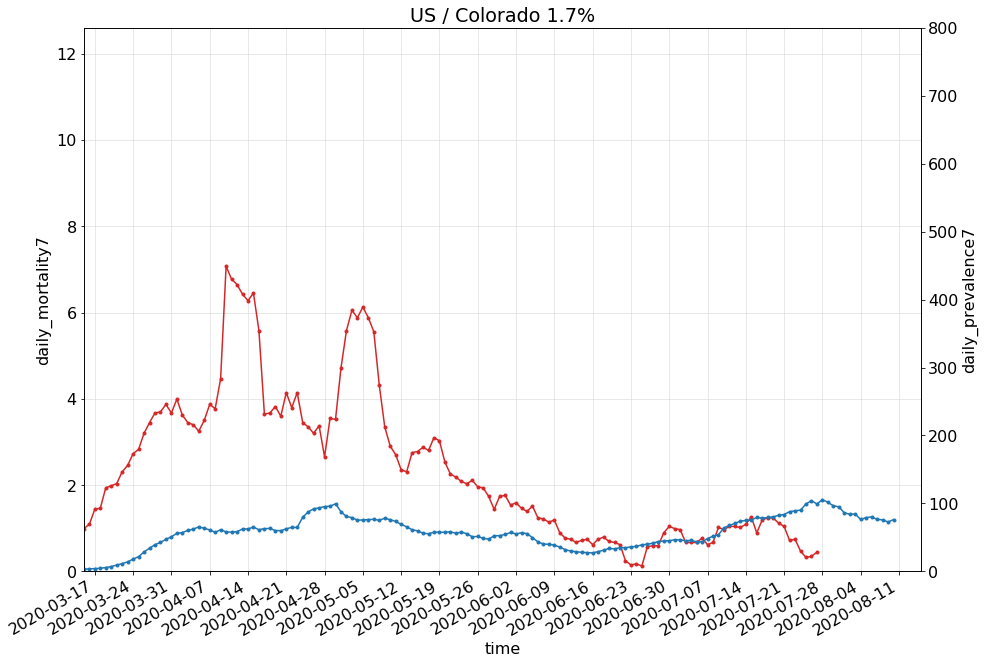

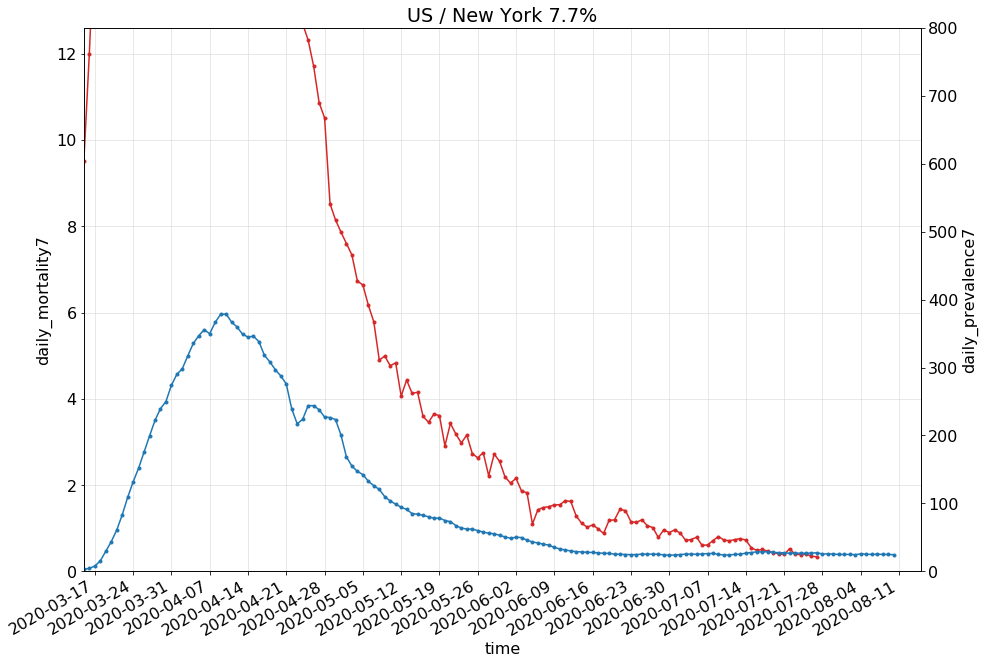

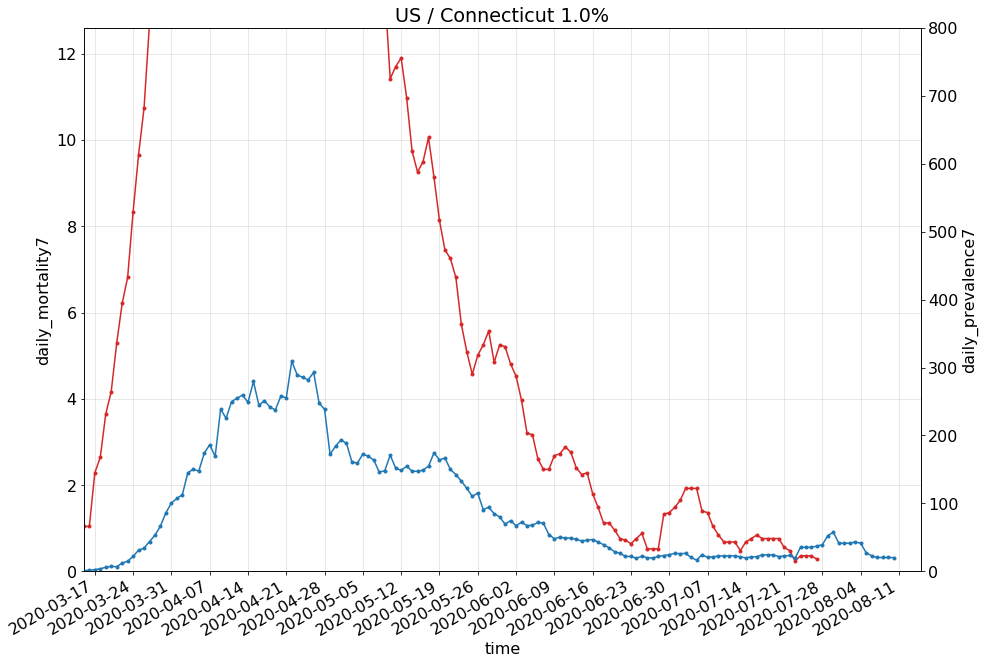

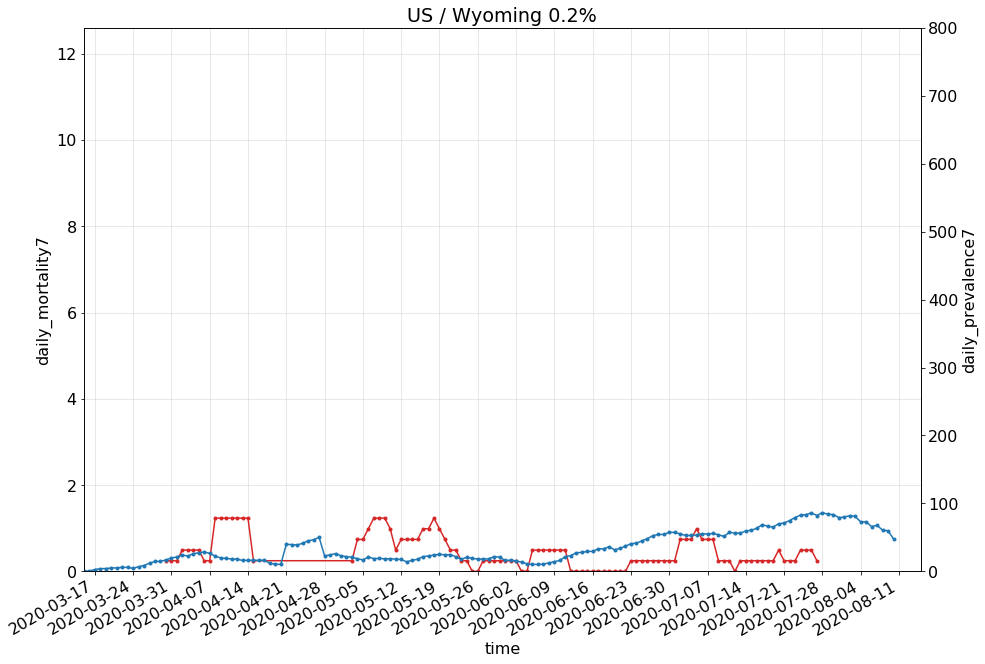

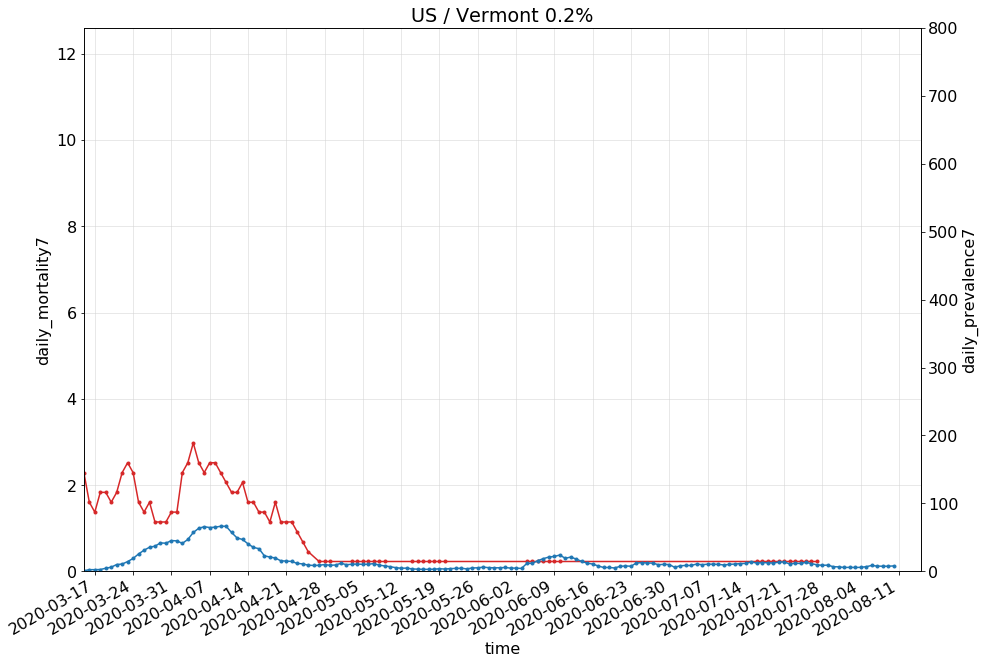

In [33]:
for region in STATES[:-8]:
    _, ax1 = plt.subplots(subplot_kw={'xlim': XLIM})

    ax1.set_title(f'COVID-19 {region} - Linear scale')
    ax1.yaxis.tick_right()
    ax1.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax1.xaxis.grid(color='lightgrey', linewidth=0.5)

    ds = ds_states.sel(location=region)

    ax2 = ax1.twinx()
    
    covid19.plot.plot_data(ax1, ds['daily_mortality7'], color=PALETTE_ONE[3], delay=-14)
    covid19.plot.plot_data(ax2, ds['daily_prevalence7'], color=PALETTE_ONE[0])

    ax1.set(ylim=(0, 800. * 0.01575), title=f"{region} {ds['population'].values / usa['population'].values * 100:.1f}%")
    ax2.set(ylim=(0, 800.), title=None)